### Section 1_Network Assesment

The dataset was originally scraped from Artfacts (https://artfacts.net) in multiple tranches, which I subsequently merged into a single corpus. The scraping of Artfacts has been conducted at Barabasi Lab previous my Co-Op. However, I enriched the dataset by scraping the ASAC (Archivio Storico delle Arti Contemporanee) of the Venice Biennale –the main focus of my research. The algorithm used was based on the Beautiful package.

After merging, I extensivly cleaned the data. The original dataset has a series of embedded dataframe which needed to be exploded. The resulting dataset was then filtered to retain only the artists who exhibited at the Venice Biennale. I additionally enriched the dataset by integrating external datasets, including for example the Global South Index.

The final core dataset consists of Venice Biennale artists and all the institutions in which they exhibited worldwide between 1895 and 2024. Each row represents a unique triplet composed of an artist ID, the year of the exhibition, and an institution ID. Worth noting that a single institution may host multiple exhibitions. Beyond the core identifiers, the dataset also includes variables such as institution name, country and city information, geographical coordinates, artist names, exhibition IDs, and institutional type (G: group exhibition, S: solo exhibition, B: biennal, F: art fair). The dataset contains a total of 2,050,734 rows. It includes 255,159 unique exhibition identifiers, 21,739 unique institutions, and 16,066 unique artists.

Having carried out the network scraping in both 2022 and 2024, the dataset is essentially complete. Still, we need to acknowledge that any new or missing data added to Artfacts after our scraping won’t be included. Having manually integrated the data scraped from the ASAC Venice Biennale records, I made sure that all artists and all editions of the exhibition are covered. This integration only refers to the Venice Biennale Arte [every two years] and not the Architecture Biennale (such as the 2025's edition), so for the purposes of this study it can be considered up to date.

Overall, after analysing potential gaps of the dataset, the dataset is extremely complete, with almost all key identifiers (institution_id, artists_id, exhibition_id, type, GS, Year) showing no missing values at all –reasnable, considering the dataset has been collected to matching institutions with artists. The only meaningful gaps appear in the geographical fields, which could be (potentially easily) improved. Country and city information have a very small percentage of missing entries (0.01–0.03%), which is negligible and unlikely to affect the analysis. The only column with substantial missingness is venue_coordinates, with around 40% NaN. This suggests that many institutions either lacked coordinate data on the source platform or did not provide it consistently over time.

#### Dataset exploration

In [ ]:
import pandas as pd
from IPython.display import HTML, display
import itertools
from collections import Counter
import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from tqdm import tqdm
import time
import random
from scipy import stats

In [42]:
# Load the CSV file
file_path = 'final_dataset.csv'
df = pd.read_csv(file_path, low_memory=False)

# Display the first rows in a scrollable table (vertical + horizontal)
html_table = df.to_html(classes='table table-striped', max_rows=10, max_cols=None)

scrollable_html = f'''
<div style="
    max-height: 400px;
    overflow-y: scroll;
    overflow-x: scroll;
    white-space: nowrap;
    border: 1px solid #ccc;
    padding: 10px;
">
    {html_table}
</div>
'''

display(HTML(scrollable_html))

In [43]:
# Number of rows and unique IDs
num_rows_data = len(df)
unique_ids_exhibition = df['exhibition_id'].nunique()
unique_ids_institution = df['institution_id'].nunique()
unique_ids_artists = df['artists_id'].nunique()

print(f"Number of rows in data: {num_rows_data}")
print(f"Number of unique IDs in exhibition: {unique_ids_exhibition}")
print(f"Number of unique IDs in institution: {unique_ids_institution}")
print(f"Number of unique IDs in artists: {unique_ids_artists}")

# Count occurrences of each type (S, G, B, F)
type_counts = df['type'].value_counts().to_dict()
print(type_counts)

Number of rows in data: 2050734
Number of unique IDs in exhibition: 255159
Number of unique IDs in institution: 21739
Number of unique IDs in artists: 16066
{'G': 1577866, 'S': 392031, 'B': 55927, 'F': 24910}


In [44]:
nan_summary = []
total_rows = len(df)

for col in df.columns:
    # count total NaNs in the column
    n_nan = df[col].isna().sum()
    
    # unique NaN: either 1 (if there is at least one NaN) or 0
    unique_nan = 1 if n_nan > 0 else 0
    
    # percentage of NaNs over total rows
    perc_nan = (n_nan / total_rows) * 100
    
    nan_summary.append({
        "column": col,
        "unique_NaN": unique_nan,
        "total_NaN": n_nan,
        "percent_NaN": round(perc_nan, 2)
    })

# Convert to DataFrame for pretty output
nan_summary_df = pd.DataFrame(nan_summary)

print(nan_summary_df)

               column  unique_NaN  total_NaN  percent_NaN
0    institution_name           0          0         0.00
1      institution_id           0          0         0.00
2        country_name           1        715         0.03
3          country_id           1        715         0.03
4           city_name           1        129         0.01
5             city_id           1        115         0.01
6   venue_coordinates           1     819532        39.96
7             artists           1      28459         1.39
8          artists_id           0          0         0.00
9                Year           0          0         0.00
10        artist_name           0          0         0.00
11      exhibition_id           0          0         0.00
12               type           0          0         0.00
13                 GS           0          0         0.00


#### Network_undirected_weighted

I create a undirected, weighted graph using NetworkX. This graph is built from the edge-list DataFrame, using institution_id_x and institution_id_y as the nodes, and weight as the edge attribute, which represents how many artists the two institutions share. The idea here is to capture the relationships and possible collaborations between institutions based on shared artists.

We could also build a bipartite network where we connect artists (set A of vertices) to institutions (set B). But that would only give us an A–B matching structure and wouldn’t really tell us much about how institutions relate to one another internally. Since the focus of the study is the Venice Biennale, it makes more sense to understand the institutional network itself (and potentially its evolution over time), following each artist’s trajectory and trying to understand their path to success. That’s why we start with a directed network of institutions.

Of course, we can flip things around and analyze a network of artists, where edges represent the institutions where two or more artists have exhibited together. But in the institution-level network we’re using right now, the weight on each edge represents the number of co-exhibiting artists across the two institutions. At this point, the network is not a multi-edge graph.

#### Network Formation

In [45]:
#Edges Formation

# Filter the Dataset only to the necessary columns
df_filtered = df[['artists_id', 'institution_id']]
artists_groups = df.groupby('artists_id')['institution_id'].apply(list)

# Generate the couple of institutions
pair_counter = Counter()

for institutions in artists_groups:
    institutions = list(set(institutions))
    if len(institutions) > 1:
        pairs = itertools.combinations(sorted(institutions), 2)
        pair_counter.update(pairs)

# Creation of new Dataframe
# Use of weighted edges to aggregate the number of collaborations between institutions
df_edge_list = pd.DataFrame(
    [(a, b, w) for (a, b), w in pair_counter.items()],
    columns=['institution_id_x', 'institution_id_y', 'weight']
)

In [46]:
# Display the head of the final edge list DataFrame
html_table = df_edge_list.head(100).to_html(
    classes='table table-striped',
    max_rows=10,
    max_cols=None
)

scrollable_html = f'''
<div style="
    max-height: 400px;
    overflow-y: scroll;
    overflow-x: scroll;
    white-space: nowrap;
    border: 1px solid #ccc;
    padding: 10px;
">
    {html_table}
</div>
'''

display(HTML(scrollable_html))

print("Number of rows in df_edge_list:", len(df_edge_list))

Number of rows in df_edge_list: 18471870


In [47]:
# Nodes Formation
df_nodes = df.copy()

# Remove duplicates from df_nodes considering only the 'institution_id' column
df_nodes = df.drop_duplicates(subset=['institution_id'], keep='first')


In [48]:
# Display the head of the final edge list DataFrame
html_table = df_nodes.head(100).to_html(
    classes='table table-striped',
    max_rows=10,
    max_cols=None
)

scrollable_html = f'''
<div style="
    max-height: 400px;
    overflow-y: scroll;
    overflow-x: scroll;
    white-space: nowrap;
    border: 1px solid #ccc;
    padding: 10px;
">
    {html_table}
</div>
'''

display(HTML(scrollable_html))
# print(f"Number of unique rows in df_nodes: {len(df)}")

In [49]:
# Create a directed weighted graph
G = nx.from_pandas_edgelist(
    df_edge_list,
    source="institution_id_x",
    target="institution_id_y",
    edge_attr="weight",
    create_using=nx.DiGraph()
)

print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

Nodes: 21739
Edges: 18471870


#### Network Visualisation

In [50]:
'''
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.15, iterations=50, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='lightblue')

nx.draw_networkx_edges(
    G, pos,
    arrowstyle='-|>',
    arrowsize=10,
    width=0.5,
    alpha=0.7
)

# Draw edge weights
# edge_labels = nx.get_edge_attributes(G, 'weight')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

# Remove axes
plt.axis('off')
plt.title("Directed Weighted Institution Network", fontsize=14)
plt.show()
'''

'\nplt.figure(figsize=(12, 10))\npos = nx.spring_layout(G, k=0.15, iterations=50, seed=42)\nnx.draw_networkx_nodes(G, pos, node_size=50, node_color=\'lightblue\')\n\nnx.draw_networkx_edges(\n    G, pos,\n    arrowstyle=\'-|>\',\n    arrowsize=10,\n    width=0.5,\n    alpha=0.7\n)\n\n# Draw edge weights\n# edge_labels = nx.get_edge_attributes(G, \'weight\')\n# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)\n\n# Remove axes\nplt.axis(\'off\')\nplt.title("Directed Weighted Institution Network", fontsize=14)\nplt.show()\n'

After waiting around 30 minutes, it became clear that the network is too large to generate a first raw visualisation. Interestingly, people on StackOverflow report having no issues plotting even larger networks, but in my case the computation just kept hanging. So, to at least get an initial sense of the structure, I proceeded with an edge-sampling approach for visualisation purposes.

In [51]:
G_original = G.copy()

def edge_sampling_with_induction_directed(G_original, n):
    """
    Perform edge sampling with induction on the directed weighted graph.
    Returns a new induced DiGraph.
    """
    # All directed edges (u, v)
    edges = list(G_original.edges(data=True))
    M = len(edges)
    
    # Sample n edges randomly (without replacement)
    sampled_idx = np.random.permutation(M)[:n]
    sampled_edges = [edges[i] for i in sampled_idx]

    # Extract nodes involved in the sampled edges
    sampled_nodes = set()
    for u, v, data in sampled_edges:
        sampled_nodes.add(u)
        sampled_nodes.add(v)

    # Induced edges: include ALL edges (u → v) between sampled nodes
    induced_edges = []
    for u, v, data in edges:
        if u in sampled_nodes and v in sampled_nodes:
            induced_edges.append((u, v, data))

    # Create new directed graph with weights
    new_G = nx.DiGraph()
    new_G.add_nodes_from(sampled_nodes)
    
    # Add edges preserving weights
    for u, v, data in induced_edges:
        new_G.add_edge(u, v, **data)

    return new_G

In [53]:
# Sample the graph (example: sample 3,000 edges)
G_sampled = edge_sampling_with_induction_directed(G_original, n=3000)

# Print size of original graph
print("Original graph:")
print("  Nodes:", G_original.number_of_nodes())
print("  Edges:", G_original.number_of_edges())

# Print size of sampled graph
print("\nSampled graph:")
print("  Nodes:", G_sampled.number_of_nodes())
print("  Edges:", G_sampled.number_of_edges())

Original graph:
  Nodes: 21739
  Edges: 18471870

Sampled graph:
  Nodes: 4344
  Edges: 3918280


In [ ]:
'''
plt.figure(figsize=(12, 10))

# Layout
pos = nx.spring_layout(G_sampled, k=0.25, iterations=40, seed=42)

# Draw nodes
nx.draw_networkx_nodes(
    G_sampled,
    pos,
    node_size=30,
    node_color="lightblue",
    alpha=0.9
)

# Draw directed edges
nx.draw_networkx_edges(
    G_sampled,
    pos,
    arrowstyle='-|>',
    arrowsize=10,
    width=0.5,
    edge_color="gray",
    alpha=0.6
)

plt.title("Sampled Directed Institution Network", fontsize=14)
plt.axis("off")
plt.show()
'''

'\nplt.figure(figsize=(12, 10))\n\n# Layout\npos = nx.spring_layout(G_sampled, k=0.25, iterations=40, seed=42)\n\n# Draw nodes\nnx.draw_networkx_nodes(\n    G_sampled,\n    pos,\n    node_size=30,\n    node_color="lightblue",\n    alpha=0.9\n)\n\n# Draw directed edges\nnx.draw_networkx_edges(\n    G_sampled,\n    pos,\n    arrowstyle=\'-|>\',\n    arrowsize=10,\n    width=0.5,\n    edge_color="gray",\n    alpha=0.6\n)\n\nplt.title("Sampled Directed Institution Network", fontsize=14)\nplt.axis("off")\nplt.show()\n'

Even with induced edge sampling, the network is still far too large to visualise in a reasonable amount of time. This already tells us —without even plotting the degree distribution— that the graph contains several major hubs. The sampling process reduced the number of nodes by roughly four-fifths and cut down the edges by about a factor of 4.5, yet the sampled graph still contains around four million edges. This means that even a relatively small subset of nodes remains highly interconnected, confirming the presence of dense institutional clusters or central institutions acting as strong hubs in the global network. Knowing that edge sampling is inherently biased towards selection of nodes with higher degrees resulting in an upward bias in the degree distributions of sampled nodes compared to nodes in the original graph, we wanted to preserve the key players. However, this make inefficient a small and fast visualisation.

Next strategy is to try with working focusing on the large component.

In [ ]:
# Largest Connected Component
gcc_nodes = max(nx.weakly_connected_components(G_sampled), key=len)
G_giant = G_sampled.subgraph(gcc_nodes).copy()

# Print sizes
print("Giant Connected Component:")
print("  Nodes:", G_giant.number_of_nodes())
print("  Edges:", G_giant.number_of_edges())

Giant Connected Component:
  Nodes: 4371
  Edges: 3932840


The number of nodes and edges remains constant, suggesting that we are already working with the giant component. This makes sense considering the difficulty an institution (node) would have working with only one artist (edge) without connecting to another institution. It seems reasonable to conclude that this result is legitimate.

We move to another strategy: k-core decomposition. After severl try and error, a suitable k-core value is around: 

In [ ]:
k = 150

# Compute k-core on the sampled graph
G_kcore = nx.k_core(G_sampled, k=k)

# Print sizes
print(f"{k}-core subgraph:")
print("  Nodes:", G_kcore.number_of_nodes())
print("  Edges:", G_kcore.number_of_edges())

150-core subgraph:
  Nodes: 4245
  Edges: 3923503



Even with a high k-core decomposition, we are unable to successfully synthesize the graph. This furhter suggests that the original network is highly skewed and heterogeneous.

To further investigate the nature of this topology, I examine the degree distribution. Plotting the degree distribution allows us to better understand the internal structure of the network and assess the presence of hubs or heavy-tailed behavior. Based on the previous observations, we hypothesize that the network contains a small number of very high-degree hubs. We will need further investigate these hubs.

/Users/jac/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


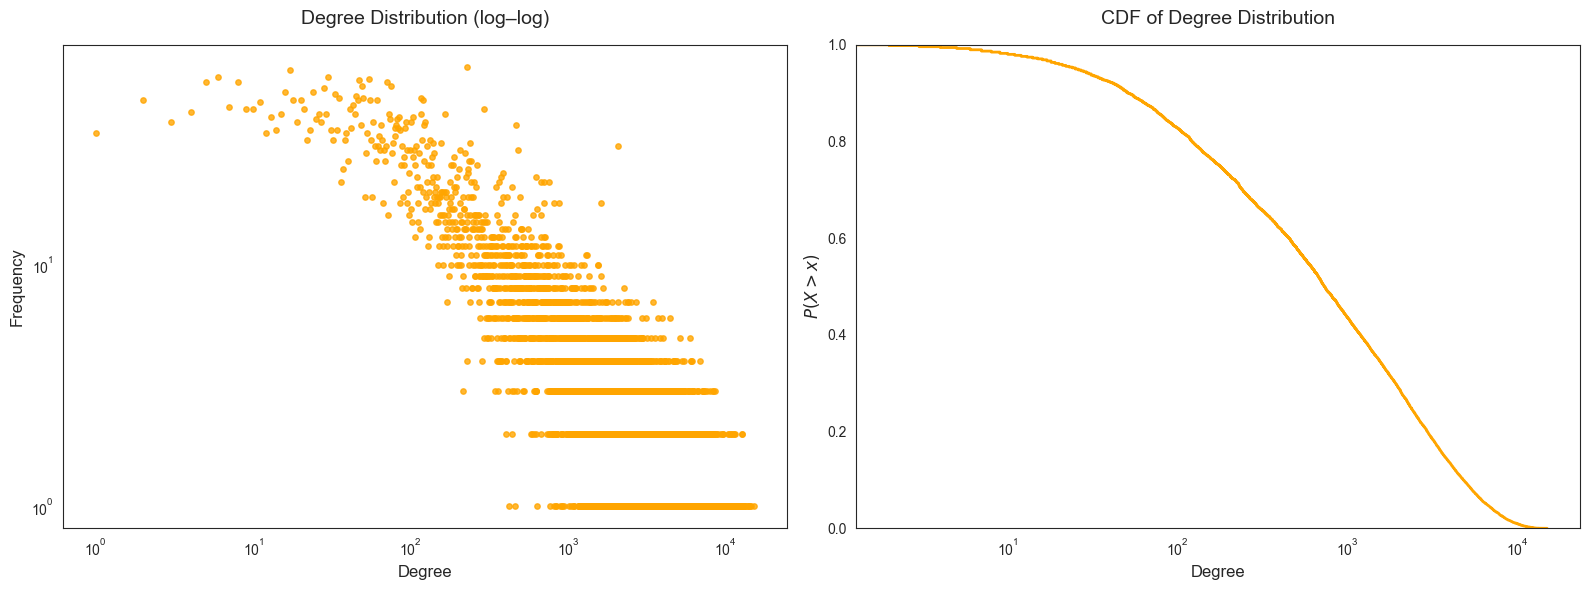

In [ ]:
sns.set_style("white")

degrees = [d for _, d in G.degree()]

# For CCDF
df = pd.DataFrame({"Degree": degrees})
df["Degree"] += 1   # avoid log(0)

# For log–log distribution
degree_count = {}
for deg in degrees:
    degree_count[deg] = degree_count.get(deg, 0) + 1

x = sorted(degree_count.keys())
y = [degree_count[k] for k in x]


# Plotting side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left PLOT — Degree Distribution (log–log)
axes[0].scatter(
    x, y,
    s=15,
    color="orange",
    alpha=0.8
)

axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_xlabel("Degree", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)
axes[0].set_title("Degree Distribution (log–log)",
                  fontsize=14, pad=15)
axes[0].grid(False)

# Rigtht PLOT — CCDF of Degree Distribution
sns.ecdfplot(
    data=df,
    x="Degree",
    log_scale=True,
    complementary=True,
    color="orange",
    linewidth=2,
    ax=axes[1]
)

axes[1].set_xlabel("Degree", fontsize=12)
axes[1].set_ylabel("$P(X > x)$", fontsize=12)
axes[1].set_title("CDF of Degree Distribution",
                  fontsize=14, pad=15)
axes[1].grid(False)
axes[1].legend([],[], frameon=False)

plt.tight_layout()
plt.show()

In [ ]:
# Top 10 Nodes by Degree
degree_dict = dict(G.degree())
top10 = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]
top10_df = pd.DataFrame(top10, columns=["institution_id", "Degree"])

df = pd.read_csv("final_dataset.csv", low_memory=False)

# Retrieve institution names
top10_with_names = top10_df.merge(
    df[["institution_id", "institution_name"]].drop_duplicates(),
    on="institution_id",
    how="left"
)

top10_with_names

institution_id  Degree                               institution_name
0             2228   15042                    Museum of Modern Art (MoMA)
1             2219   14513                                Centre Pompidou
2             2219   14513                    BPI Centre Georges Pompidou
3             2259   14337             ZKM | Zentrum für Kunst und Medien
4             1807   14119      Museo Nacional Centro de Arte Reina Sofía
5             2367   13803                         La Biennale di Venezia
6             1234   13752                                       MoMA PS1
7             2277   13345  Museum Moderner Kunst Stiftung Ludwig (MUMOK)
8             2247   13313    Institute of Contemporary Arts London (ICA)
9             1137   13086                         Kunstverein in Hamburg
10            2546   12963                             Martin-Gropius-Bau

This result is nonetheless surprising. After filtering the initial dataset through the artists who exhibited at the Venice Biennale, we would have expected the VB to appear as the major hub—meaning it should be connected to all nodes in the giant component.

However, since the nodes in our network are institutions, not exhibitions, this outcome can also be explained by the fact that an artist may have exhibited more frequently at other institutions than at the VB throughout their career. Still, even under that assumption, we are working with a single-edge degree (weighted): once we filter by unique institution pairs, multiple exhibitions between the same two institutions collapse into a single connection.

This makes the observation even more unexpected and suggests that the structure of the filtered network should be examined more closely. Further investigation is needed to understand why the VB does not emerge as the central hub in this configuration.

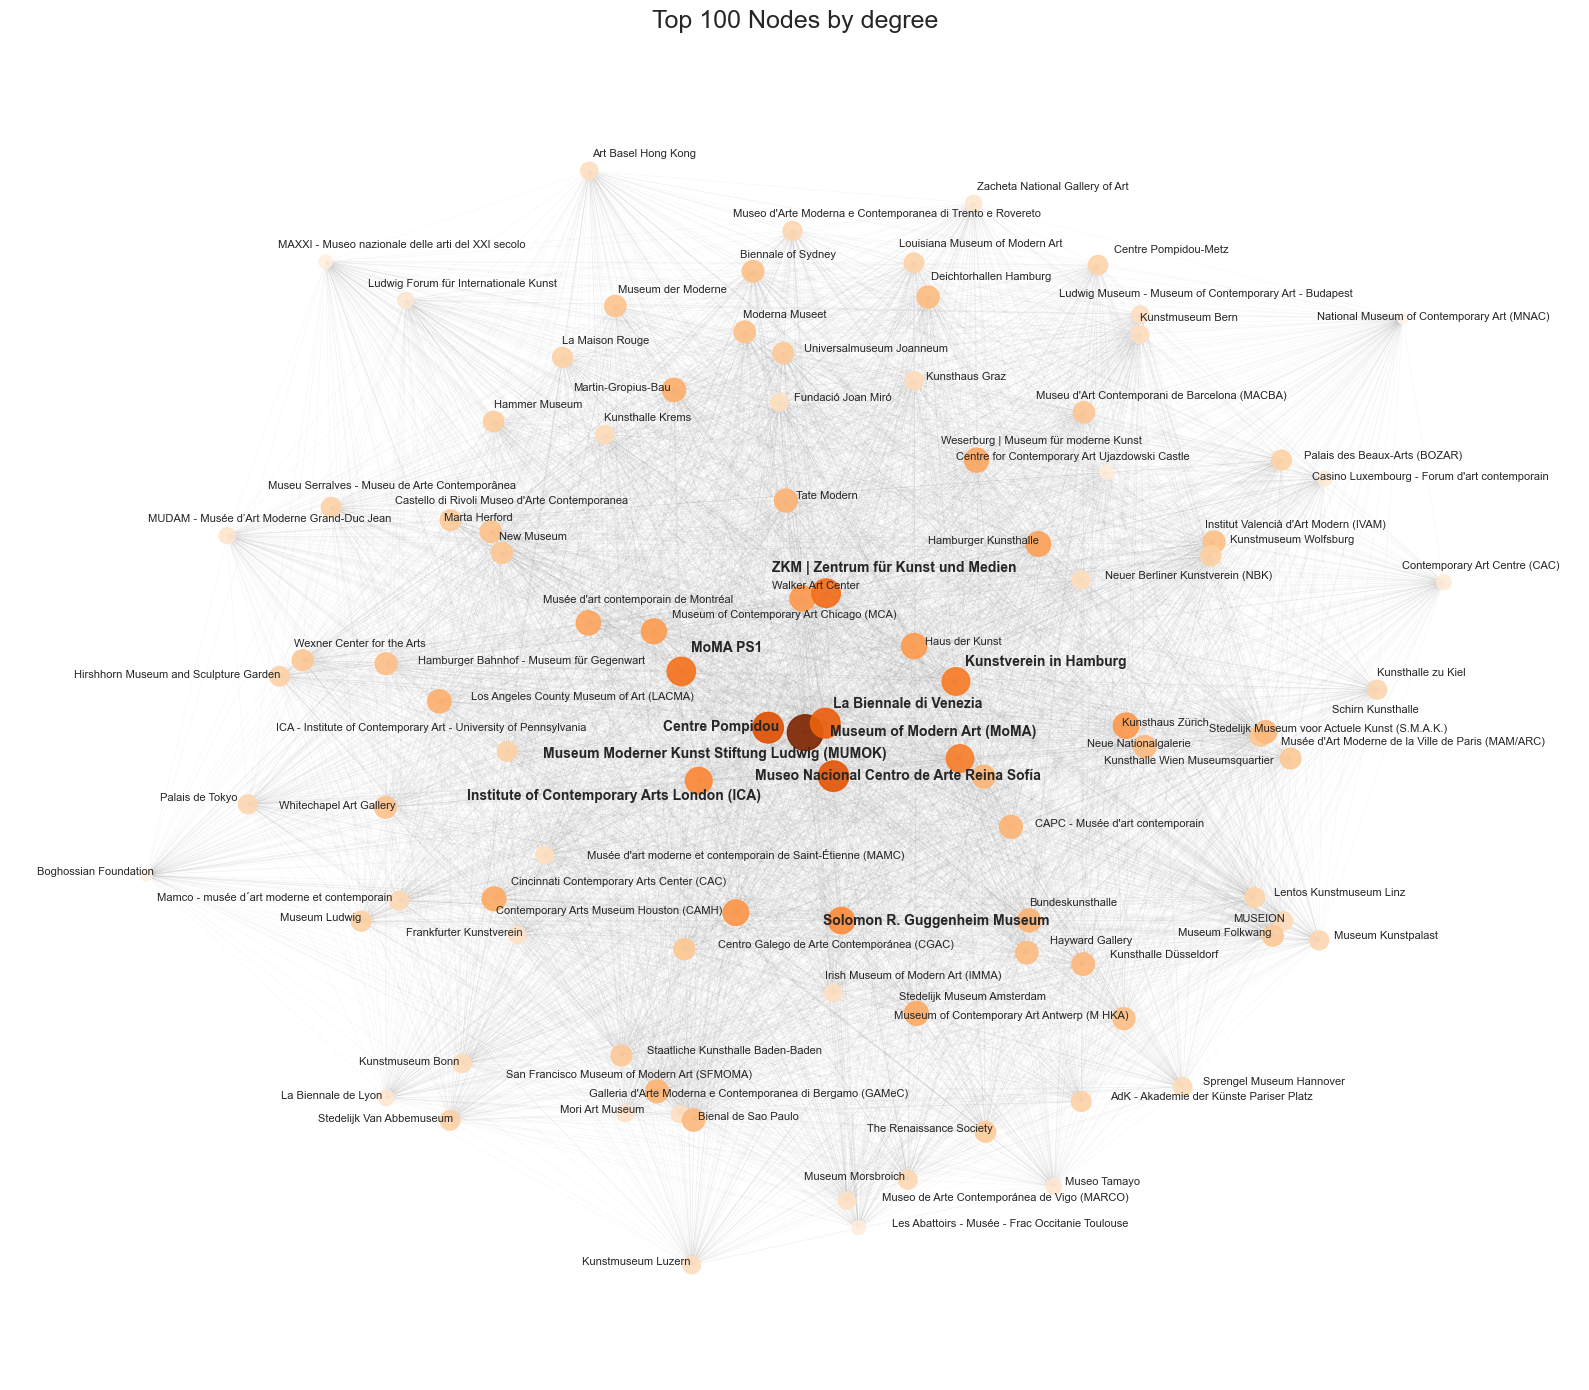

In [ ]:
# Top 100 nodes by degree sorted
degree_dict = dict(G.degree())
top100_nodes = [n for n, d in sorted(degree_dict.items(),
                                     key=lambda x: x[1],
                                     reverse=True)[:100]]

G_sub = G.subgraph(top100_nodes).copy()
G_sub = nx.Graph(G_sub)


# Weighted degree
deg_w = dict(G_sub.degree(weight="weight"))
deg_vals = np.array(list(deg_w.values()), dtype=float)


# Normalize degree to 0–100 for better visualization
min_deg, max_deg = deg_vals.min(), deg_vals.max()
range_deg = max_deg - min_deg if max_deg != min_deg else 1

norm_deg = 100 * (deg_vals - min_deg) / range_deg
norm_deg_dict = dict(zip(G_sub.nodes(), norm_deg))

# For a stronger size difference
node_sizes = (norm_deg * 6) + 60


# Institution names for nodes
name_dict = dict(zip(
    df["institution_id"],
    df["institution_name"]
))

# Bolder labels for top 10% hubs
threshold = np.percentile(norm_deg, 90)


# Spring layout
pos = nx.spring_layout(
    G_sub, seed=42,
    k=0.22,
    iterations=70
)


# Plot
plt.figure(figsize=(16, 14))

nx.draw_networkx_nodes(
    G_sub, pos,
    node_size=node_sizes,
    node_color=norm_deg,
    cmap="Oranges",
    alpha=0.92
)

nx.draw_networkx_edges(
    G_sub, pos,
    width=0.3,
    alpha=0.10,
    edge_color="gray"
)


# Labels "hovering" each node
texts = []
for node in G_sub.nodes():
    x, y = pos[node]
    label = name_dict.get(node, str(node))

    # bold hubs
    if norm_deg_dict[node] >= threshold:
        weight = "bold"
        fontsize = 10
    else:
        weight = "normal"
        fontsize = 8

    # Placing the text slightly above the node
    t = plt.text(
        x, y + 0.015, 
        label,
        fontsize=fontsize,
        fontweight=weight,
        ha='center',
        va='center'
    )
    texts.append(t)


# Adjust labels WITHOUT letting them drift away
adjust_text(
    texts,
    only_move={'points':'y', 'texts':'y'},  # move labels only vertically
    autoalign=False,
    expand=(1.01, 1.05),                    # minimal movement allowed
    force_text=0.2,
    force_points=0.2,
    lim=10                                  # limits how far labels can move
)

plt.title("Top 100 Nodes by degree",
          fontsize=18, pad=20)

plt.axis("off")
plt.tight_layout()
plt.show()


Another direction could be to filter by the strength of the edges (weights). In fact, we can hypothesize that the top-degree nodes will have shared many strong connections, while many low-degree nodes will share only weak connections with others. By filtering out these low-strength edges, the analysis would focus more on the major trends, potentially eliminating a large number of low-information edges. Let's start by plotting the distribution of the edges' strenght.

In [ ]:
weights = df_edge_list["weight"].tolist()

# Avoid log(0)
df_w = pd.DataFrame({"Weight": weights})
df_w["Weight"] += 1

# Log–log distribution (weight frequency)
weight_count = {}
for w in weights:
    weight_count[w] = weight_count.get(w, 0) + 1

x_w = sorted(weight_count.keys())
y_w = [weight_count[k] for k in x_w]

/Users/jac/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/hz/8_pbd_z510s72pvrq_72td3c0000gn/T/ipykernel_84979/4259445954.py:39: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/jac/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


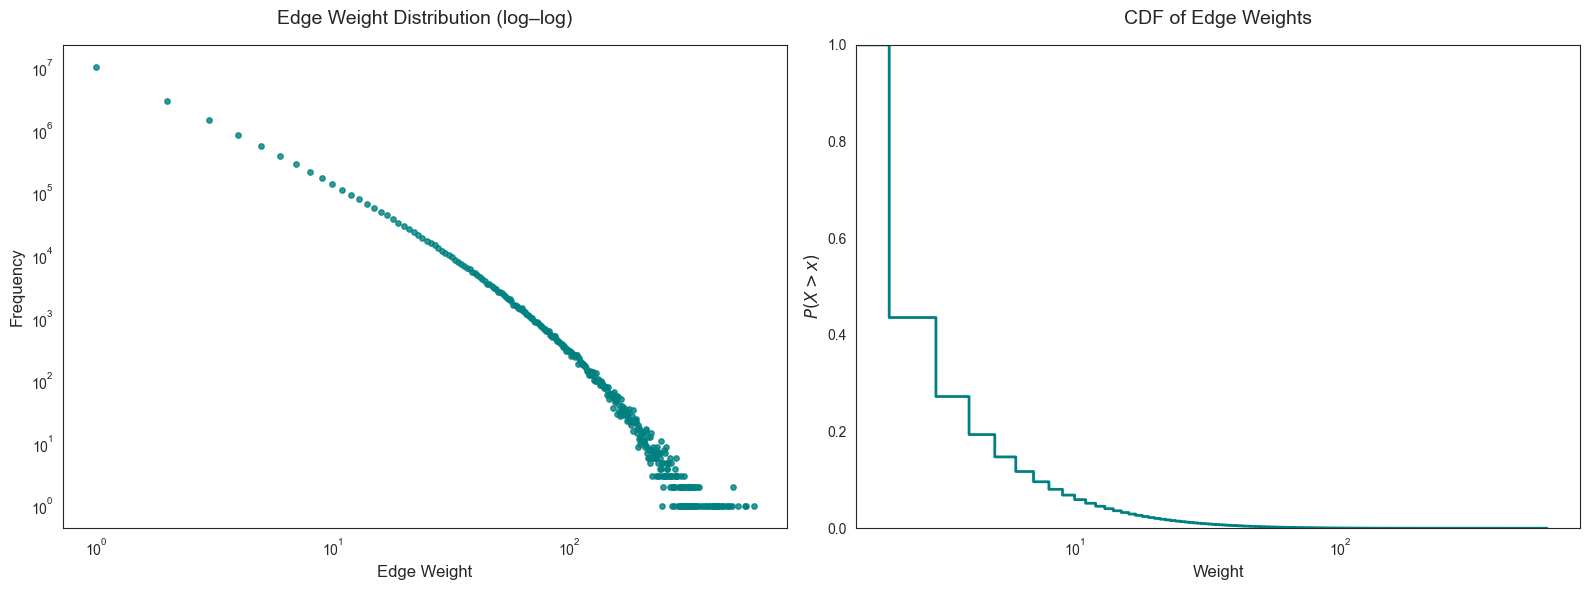

In [ ]:
# Plotting side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# LEFT PLOT: Weight Distribution (log–log)
axes[0].scatter(
    x_w, y_w,
    s=15,
    color="teal",
    alpha=0.8
)

axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_xlabel("Edge Weight", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)
axes[0].set_title("Edge Weight Distribution (log–log)",
                  fontsize=14, pad=15)
axes[0].grid(False)


# RIGHT PLOT: CCDF of Edge Weights
sns.ecdfplot(
    data=df_w,
    x="Weight",
    log_scale=True,
    complementary=True,
    color="teal",
    linewidth=2,
    ax=axes[1]
)

axes[1].set_xlabel("Weight", fontsize=12)
axes[1].set_ylabel("$P(X > x)$", fontsize=12)
axes[1].set_title("CDF of Edge Weights",
                  fontsize=14, pad=15)
axes[1].grid(False)
axes[1].legend([], [], frameon=False)

plt.tight_layout()
plt.show()

The edge-weight distributions reveal a network characterized by strong heterogeneity in institutional collaborations. Most edges have very low weights. This indicates weak or infrequent connections, while only a small number of institutional pairs share a high frequency of interactions. The log–log plot highlights a clear long-tail pattern, suggesting that a few very strong links dominate the structure, as we expected. The CCDF also confirms this imbalance: the probability of observing high-weight edges decreases rapidly, making such cases extremely rare. We can move forward by filtering the low-weight edges out, in order to have a more managible network to work with.

In [ ]:
thresholds = [5, 10, 15, 20, 30, 50, 75, 100]

for t in thresholds:
    # Filter
    df_edge_filtered = df_edge_list[df_edge_list["weight"] > t].copy()

    # Create graph from filtered edges
    G = nx.from_pandas_edgelist(
        df_edge_filtered,
        source="institution_id_x",
        target="institution_id_y",
        edge_attr="weight",
        create_using=nx.Graph()
    )

    # Compute stats
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()

    print(f"Threshold > {t}:")
    print(f"  Nodes: {num_nodes}")
    print(f"  Edges: {num_edges}")
    print("-" * 30)

Threshold > 5:
  Nodes: 9051
  Edges: 2168434
------------------------------
Threshold > 10:
  Nodes: 5933
  Edges: 955283
------------------------------
Threshold > 15:
  Nodes: 4371
  Edges: 542781
------------------------------
Threshold > 20:
  Nodes: 3433
  Edges: 345691
------------------------------
Threshold > 30:
  Nodes: 2355
  Edges: 169720
------------------------------
Threshold > 50:
  Nodes: 1382
  Edges: 58711
------------------------------
Threshold > 75:
  Nodes: 842
  Edges: 21602
------------------------------
Threshold > 100:
  Nodes: 550
  Edges: 9416
------------------------------


Giant component: 548 nodes, 9415 edges


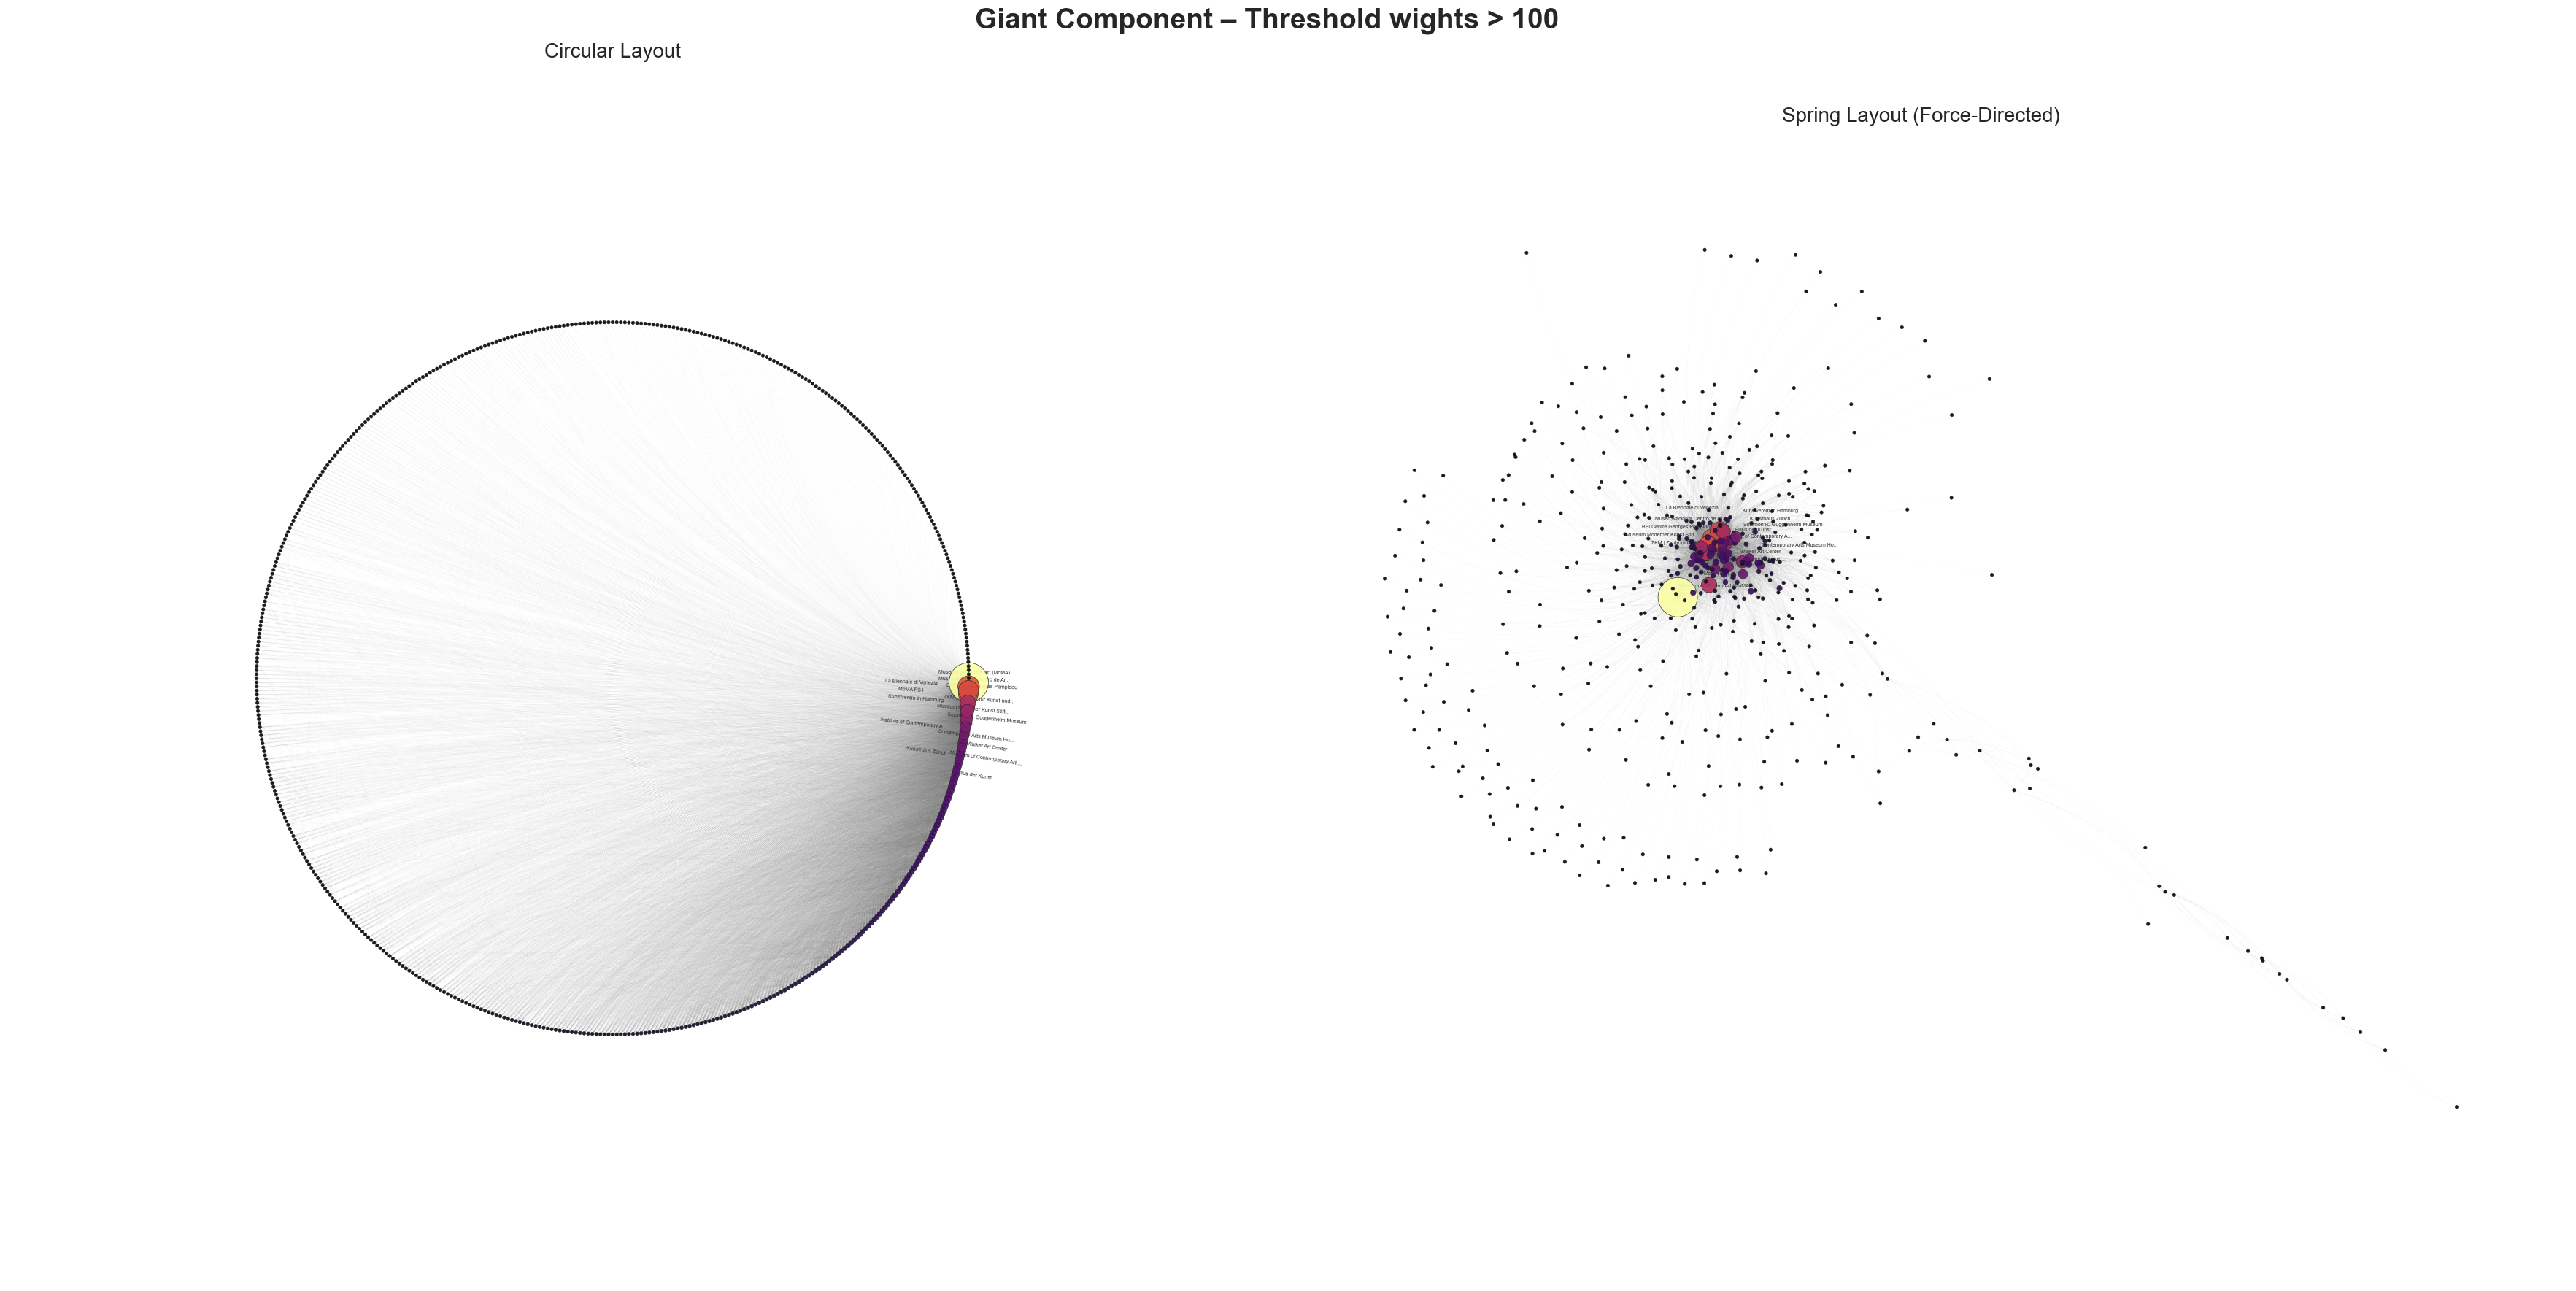

In [ ]:
# Build graph filtering edges with weight > 100
df_edge_filtered_100 = df_edge_list[df_edge_list["weight"] > 100].copy()

G_threshold100 = nx.from_pandas_edgelist(
    df_edge_filtered_100,
    source="institution_id_x",
    target="institution_id_y",
    edge_attr="weight",
    create_using=nx.Graph()
)


# Extract Giant Component
components = list(nx.connected_components(G_threshold100))
largest_cc = max(components, key=len)
G_giant = G_threshold100.subgraph(largest_cc).copy()

print(f"Giant component: {G_giant.number_of_nodes()} nodes, {G_giant.number_of_edges()} edges")


# Weighted degree normalization
deg_w = dict(G_giant.degree(weight="weight"))
deg_vals = np.array(list(deg_w.values()), dtype=float)

min_deg, max_deg = deg_vals.min(), deg_vals.max()
range_deg = max_deg - min_deg if max_deg != min_deg else 1

norm_deg = (deg_vals - min_deg) / range_deg
norm_deg_dict = dict(zip(G_giant.nodes(), norm_deg))

# Make the size scaling more drastic
node_size_dict = {n: 10 + (norm_deg_dict[n] ** 2.5) * 1500 for n in G_giant.nodes()}

# Top 15 nodes for labeling
top15_nodes = [
    n for n, d in sorted(deg_w.items(),
                         key=lambda x: x[1],
                         reverse=True)[:15]
]


# Mapping institution_id to institution_name
df_unique_institutions = df[["institution_id", "institution_name"]].drop_duplicates()
id_to_name = dict(zip(df_unique_institutions["institution_id"], df_unique_institutions["institution_name"]))


# 5. Create 2 layouts

# CIRCULAR LAYOUT sorted by degree
sorted_nodes = sorted(G_giant.nodes(), key=lambda x: deg_w.get(x, 0))
n_nodes = len(sorted_nodes)

pos_circular = {}
for i, node in enumerate(sorted_nodes):
    angle = 2 * np.pi * i / n_nodes
    pos_circular[node] = (np.cos(angle), np.sin(angle))

# SPRING LAYOUT
pos_spring = nx.spring_layout(
    G_giant,
    seed=42,
    k=2.5 / np.sqrt(G_giant.number_of_nodes()),
    iterations=150,
    scale=1.0
)


# Draw curved edges
def draw_curved_edges(G, pos, ax, alpha=0.03, color="#4a4a4a", curve_to_center=True):
    """Draw edges as curved lines"""
    for (u, v) in G.edges():
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        
        dist = np.sqrt((x1-x0)**2 + (y1-y0)**2)
        
        if curve_to_center:
            # Pull toward center (for circular layout)
            curve_strength = 0.2 * dist
            mx, my = (x0 + x1) / 2, (y0 + y1) / 2
            cx, cy = mx * (1 - curve_strength), my * (1 - curve_strength)
        else:
            # Perpendicular curve (for spring layout)
            mx, my = (x0 + x1) / 2, (y0 + y1) / 2
            dx, dy = x1 - x0, y1 - y0
            # Perpendicular offset
            curve_strength = 0.15 * dist
            cx = mx - dy * curve_strength / (dist + 0.001)
            cy = my + dx * curve_strength / (dist + 0.001)
        
        # Create quadratic Bézier curve
        t = np.linspace(0, 1, 30)
        bx = (1-t)**2 * x0 + 2*(1-t)*t * cx + t**2 * x1
        by = (1-t)**2 * y0 + 2*(1-t)*t * cy + t**2 * y1
        
        ax.plot(bx, by, color=color, alpha=alpha, linewidth=0.3, solid_capstyle='round')


# Add labels
def add_labels(pos, top_nodes, id_to_name, ax, layout_type="circular"):
    texts = []
    for node in top_nodes:
        x, y = pos[node]
        
        label = id_to_name.get(node, str(node))
        if len(label) > 30:
            label = label[:27] + "..."
        
        if layout_type == "circular":
            # Position outside the circle
            angle = np.arctan2(y, x)
            label_distance = 1.12
            label_x = label_distance * np.cos(angle)
            label_y = label_distance * np.sin(angle)
            
            ha = "left" if x >= 0 else "right"
            
            rot_angle = np.degrees(angle)
            if rot_angle > 90:
                rot_angle -= 180
            elif rot_angle < -90:
                rot_angle += 180
        else:
            # Spring layout: position near node
            label_x, label_y = x, y + 0.02
            ha = "center"
            rot_angle = 0
        
        t = ax.text(
            label_x, label_y,
            label,
            fontsize=5,
            fontweight="medium",
            color="#333333",
            ha=ha,
            va="center",
            rotation=rot_angle,
            rotation_mode="anchor"
        )
        texts.append(t)
    
    # Adjust overlapping labels
    adjust_text(
        texts,
        expand_points=(1.1, 1.1),
        expand_text=(1.05, 1.05),
        force_points=0.2,
        force_text=0.4,
        lim=50,
        ax=ax
    )


# Plotting side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(36, 18))
fig.patch.set_facecolor('white')

# Main title
fig.suptitle(
    "Giant Component – Threshold wights > 100",
    fontsize=28,
    fontweight="bold",
    y=0.98
)

# LEFT: CIRCULAR LAYOUT
ax1.set_facecolor('white')
ax1.set_title("Circular Layout", fontsize=20, pad=15)

# Draw curved edges
draw_curved_edges(G_giant, pos_circular, ax1, alpha=0.04, color="#555555", curve_to_center=True)

# Draw nodes
node_list = list(G_giant.nodes())
node_colors = [norm_deg_dict[n] for n in node_list]
node_sizes = [node_size_dict[n] for n in node_list]

ax1.scatter(
    [pos_circular[n][0] for n in node_list],
    [pos_circular[n][1] for n in node_list],
    s=node_sizes,
    c=node_colors,
    cmap="inferno",
    alpha=0.9,
    edgecolors="#222222",
    linewidths=0.5,
    zorder=10
)

# Add labels
add_labels(pos_circular, top15_nodes, id_to_name, ax1, layout_type="circular")

ax1.set_aspect('equal')
ax1.set_xlim(-1.7, 1.7)
ax1.set_ylim(-1.7, 1.7)
ax1.axis("off")

# RIGHT: SPRING LAYOUT
ax2.set_facecolor('white')
ax2.set_title("Spring Layout (Force-Directed)", fontsize=20, pad=15)

# Draw curved edges
draw_curved_edges(G_giant, pos_spring, ax2, alpha=0.04, color="#555555", curve_to_center=False)

# Draw nodes
ax2.scatter(
    [pos_spring[n][0] for n in node_list],
    [pos_spring[n][1] for n in node_list],
    s=node_sizes,
    c=node_colors,
    cmap="inferno",
    alpha=0.9,
    edgecolors="#222222",
    linewidths=0.5,
    zorder=10
)

# Add labels
add_labels(pos_spring, top15_nodes, id_to_name, ax2, layout_type="spring")

ax2.set_aspect('equal')
# Auto-scale for spring layout
x_coords = [pos_spring[n][0] for n in node_list]
y_coords = [pos_spring[n][1] for n in node_list]
margin = 0.15
ax2.set_xlim(min(x_coords) - margin, max(x_coords) + margin)
ax2.set_ylim(min(y_coords) - margin, max(y_coords) + margin)
ax2.axis("off")

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig("network_comparison.png", dpi=300, facecolor="white", bbox_inches="tight")
plt.show()

We now apply a degree filter to the network. However, we forsee minimal divergence from the previous iteration, as nodes with high degree centrality typically correlate with those exhibiting high edge weights—a relationship consistent with preferential attachment dynamics in institutional networks.

Original giant component: 548 nodes, 9415 edges
Filtered (top 100 nodes): 100 nodes, 4190 edges


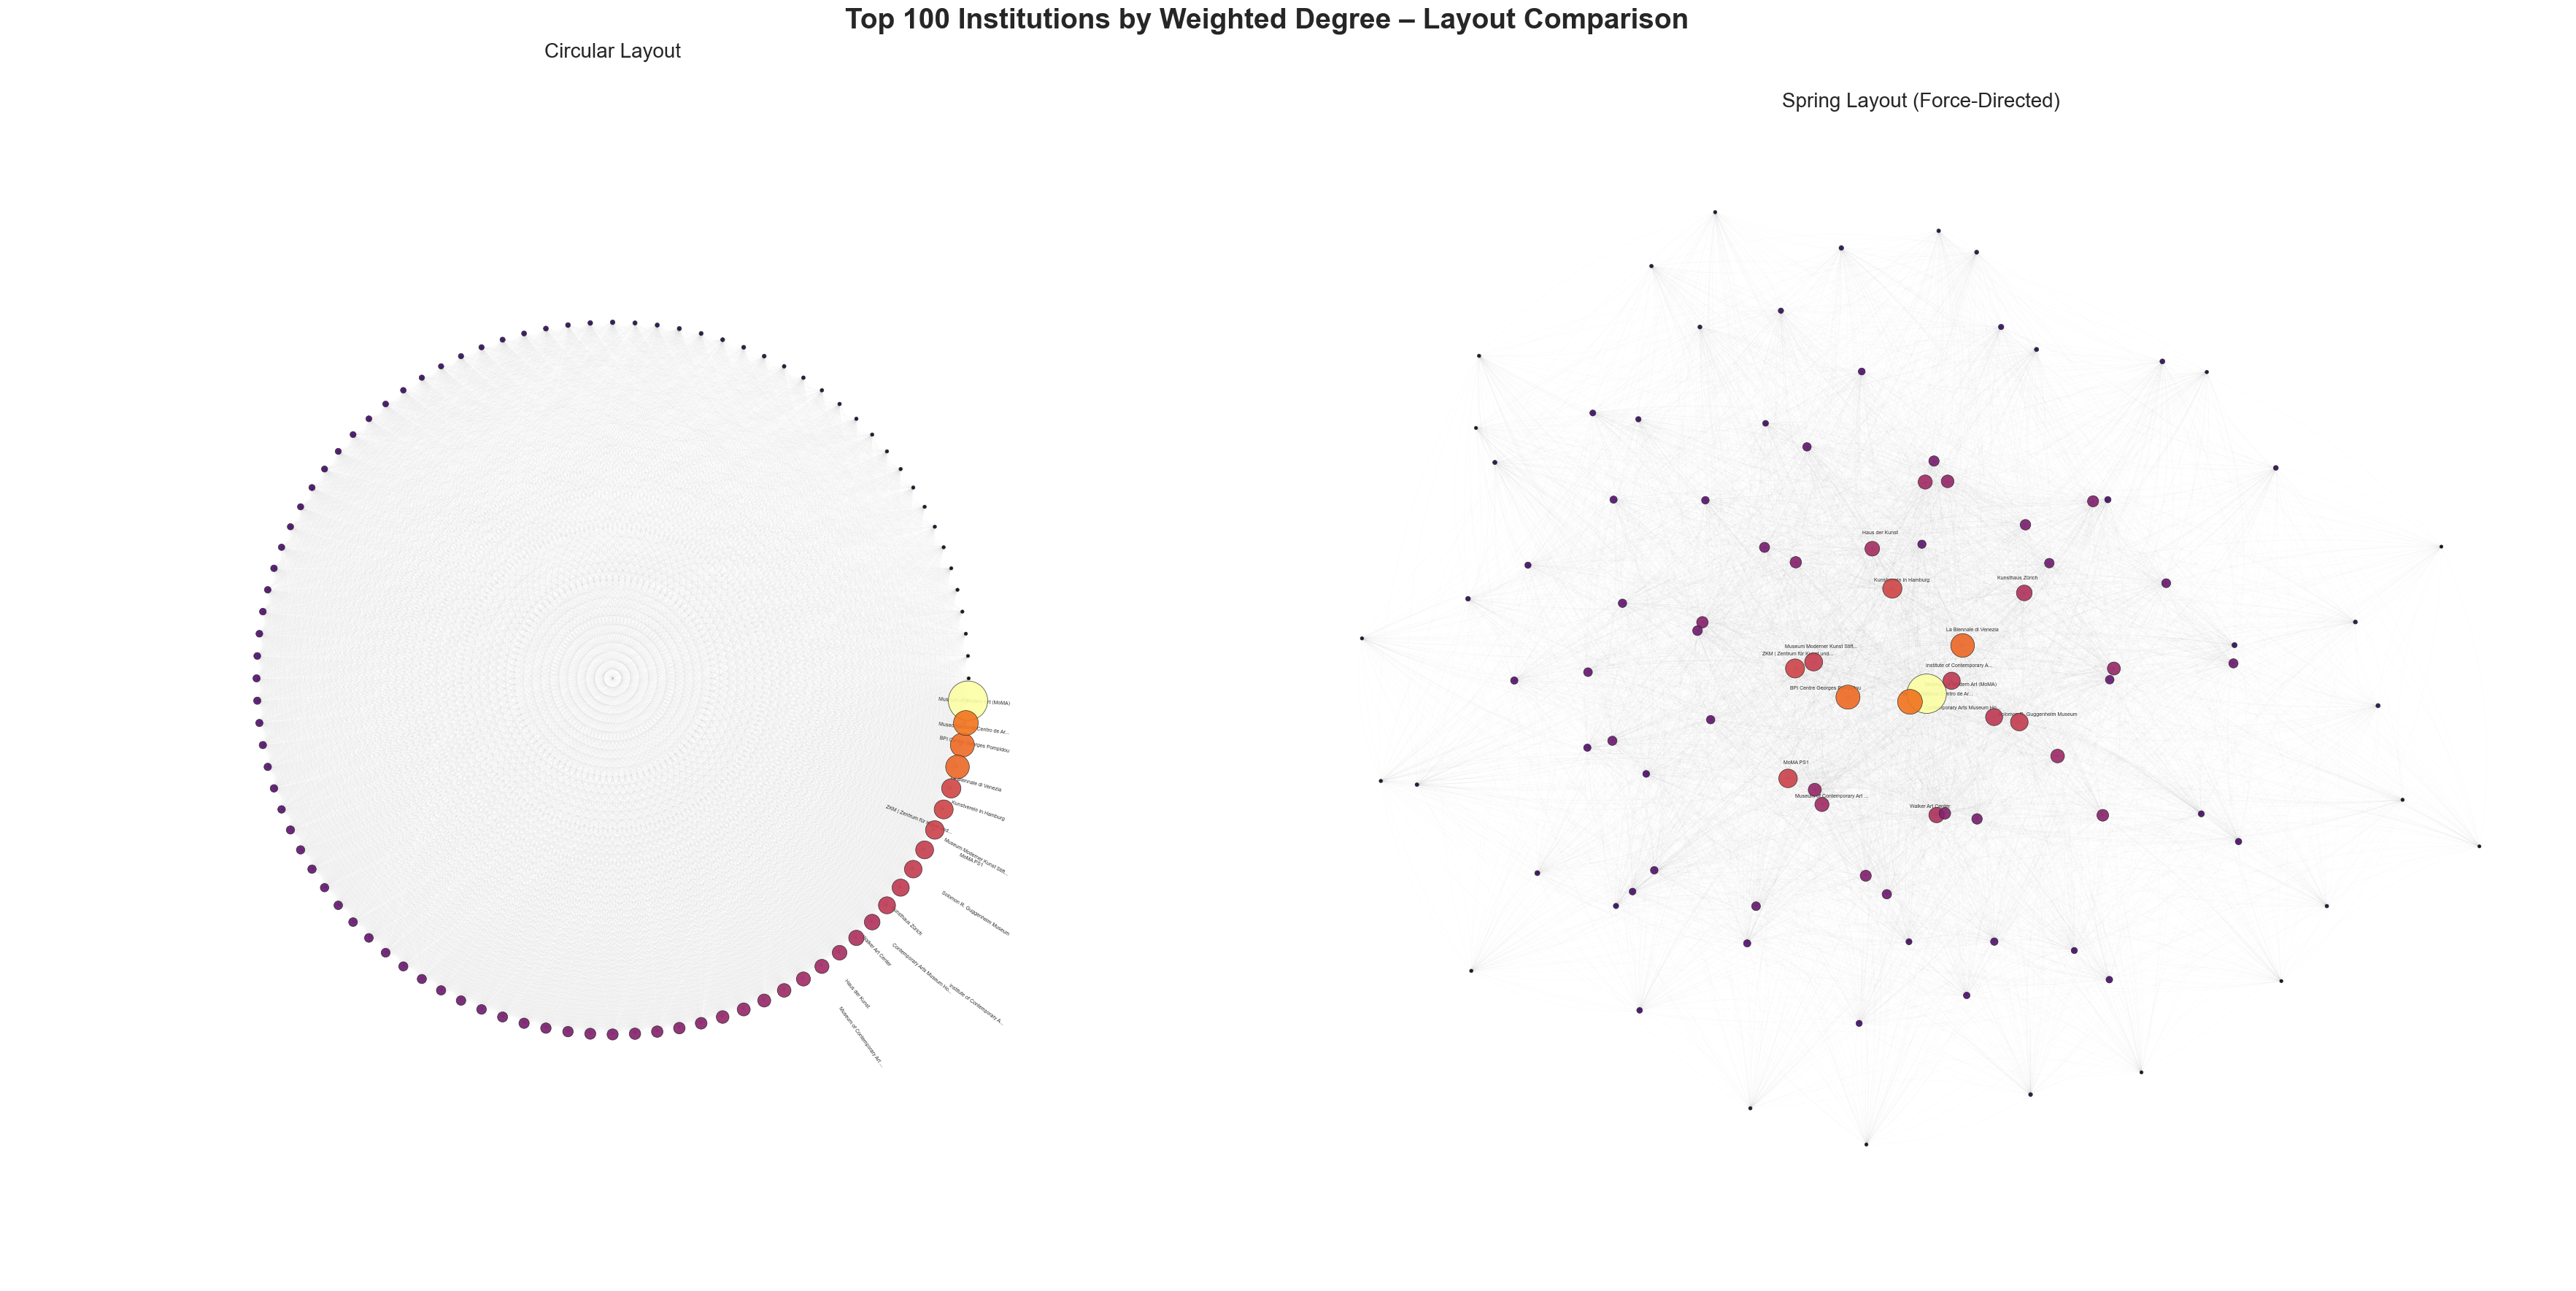

In [ ]:
# Load Data

file_path = 'final_dataset.csv'
df = pd.read_csv(file_path, low_memory=False)

#Build graph filtering edges with weight > 100
df_edge_filtered_100 = df_edge_list[df_edge_list["weight"] > 100].copy()

G_threshold100 = nx.from_pandas_edgelist(
    df_edge_filtered_100,
    source="institution_id_x",
    target="institution_id_y",
    edge_attr="weight",
    create_using=nx.Graph()
)

# Extract Giant Component
components = list(nx.connected_components(G_threshold100))
largest_cc = max(components, key=len)
G_giant_full = G_threshold100.subgraph(largest_cc).copy()


# Filter to keep only top 100 highest weighted degree nodes
deg_w_full = dict(G_giant_full.degree(weight="weight"))

# Get top 100 nodes by weighted degree
top100_nodes_list = [
    n for n, d in sorted(deg_w_full.items(),
                         key=lambda x: x[1],
                         reverse=True)[:100]
]

# Create subgraph with only these top 100 nodes
G_giant = G_giant_full.subgraph(top100_nodes_list).copy()

print(f"Original giant component: {G_giant_full.number_of_nodes()} nodes, {G_giant_full.number_of_edges()} edges")
print(f"Filtered (top 100 nodes): {G_giant.number_of_nodes()} nodes, {G_giant.number_of_edges()} edges")


# Weighted degree normalization (on filtered graph)
deg_w = dict(G_giant.degree(weight="weight"))
deg_vals = np.array(list(deg_w.values()), dtype=float)

min_deg, max_deg = deg_vals.min(), deg_vals.max()
range_deg = max_deg - min_deg if max_deg != min_deg else 1

norm_deg = (deg_vals - min_deg) / range_deg
norm_deg_dict = dict(zip(G_giant.nodes(), norm_deg))

# Drastic size scaling
node_size_dict = {n: 10 + (norm_deg_dict[n] ** 2.5) * 1500 for n in G_giant.nodes()}

# Top 15 nodes for labeling
top15_nodes = [
    n for n, d in sorted(deg_w.items(),
                         key=lambda x: x[1],
                         reverse=True)[:15]
]


# Create ID -> Institution Name mapping
df_unique_institutions = df[["institution_id", "institution_name"]].drop_duplicates()
id_to_name = dict(zip(df_unique_institutions["institution_id"], df_unique_institutions["institution_name"]))

# Create BOTH layouts

# CIRCULAR LAYOUT (sorted by degree)
sorted_nodes = sorted(G_giant.nodes(), key=lambda x: deg_w.get(x, 0))
n_nodes = len(sorted_nodes)

pos_circular = {}
for i, node in enumerate(sorted_nodes):
    angle = 2 * np.pi * i / n_nodes
    pos_circular[node] = (np.cos(angle), np.sin(angle))

# SPRING LAYOUT
pos_spring = nx.spring_layout(
    G_giant,
    seed=42,
    k=2.5 / np.sqrt(G_giant.number_of_nodes()),
    iterations=150,
    scale=1.0
)

# Function to draw curved edges
def draw_curved_edges(G, pos, ax, alpha=0.03, color="#4a4a4a", curve_to_center=True):
    """Draw edges as curved lines"""
    for (u, v) in G.edges():
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        
        dist = np.sqrt((x1-x0)**2 + (y1-y0)**2)
        
        if curve_to_center:
            # Pull toward center (for circular layout)
            curve_strength = 0.2 * dist
            mx, my = (x0 + x1) / 2, (y0 + y1) / 2
            cx, cy = mx * (1 - curve_strength), my * (1 - curve_strength)
        else:
            # Perpendicular curve (for spring layout)
            mx, my = (x0 + x1) / 2, (y0 + y1) / 2
            dx, dy = x1 - x0, y1 - y0
            # Perpendicular offset
            curve_strength = 0.15 * dist
            cx = mx - dy * curve_strength / (dist + 0.001)
            cy = my + dx * curve_strength / (dist + 0.001)
        
        # Create quadratic Bézier curve
        t = np.linspace(0, 1, 30)
        bx = (1-t)**2 * x0 + 2*(1-t)*t * cx + t**2 * x1
        by = (1-t)**2 * y0 + 2*(1-t)*t * cy + t**2 * y1
        
        ax.plot(bx, by, color=color, alpha=alpha, linewidth=0.3, solid_capstyle='round')

# Function to add labels
def add_labels(pos, top_nodes, id_to_name, ax, layout_type="circular"):
    texts = []
    for node in top_nodes:
        x, y = pos[node]
        
        label = id_to_name.get(node, str(node))
        if len(label) > 30:
            label = label[:27] + "..."
        
        if layout_type == "circular":
            # Position outside the circle
            angle = np.arctan2(y, x)
            label_distance = 1.12
            label_x = label_distance * np.cos(angle)
            label_y = label_distance * np.sin(angle)
            
            ha = "left" if x >= 0 else "right"
            
            rot_angle = np.degrees(angle)
            if rot_angle > 90:
                rot_angle -= 180
            elif rot_angle < -90:
                rot_angle += 180
        else:
            # Spring layout: position near node
            label_x, label_y = x, y + 0.02
            ha = "center"
            rot_angle = 0
        
        t = ax.text(
            label_x, label_y,
            label,
            fontsize=5,
            fontweight="medium",
            color="#333333",
            ha=ha,
            va="center",
            rotation=rot_angle,
            rotation_mode="anchor"
        )
        texts.append(t)
    
    # Adjust overlapping labels
    adjust_text(
        texts,
        expand_points=(1.1, 1.1),
        expand_text=(1.05, 1.05),
        force_points=0.2,
        force_text=0.4,
        lim=50,
        ax=ax
    )

# PLOTTING - SIDE BY SIDE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(36, 18))
fig.patch.set_facecolor('white')

# Main title
fig.suptitle(
    "Top 100 Institutions by Weighted Degree – Layout Comparison",
    fontsize=28,
    fontweight="bold",
    y=0.98
)

# LEFT: CIRCULAR LAYOUT
ax1.set_facecolor('white')
ax1.set_title("Circular Layout", fontsize=20, pad=15)

# Draw curved edges
draw_curved_edges(G_giant, pos_circular, ax1, alpha=0.04, color="#555555", curve_to_center=True)

# Draw nodes
node_list = list(G_giant.nodes())
node_colors = [norm_deg_dict[n] for n in node_list]
node_sizes = [node_size_dict[n] for n in node_list]

ax1.scatter(
    [pos_circular[n][0] for n in node_list],
    [pos_circular[n][1] for n in node_list],
    s=node_sizes,
    c=node_colors,
    cmap="inferno",
    alpha=0.9,
    edgecolors="#222222",
    linewidths=0.5,
    zorder=10
)

# Add labels
add_labels(pos_circular, top15_nodes, id_to_name, ax1, layout_type="circular")

ax1.set_aspect('equal')
ax1.set_xlim(-1.7, 1.7)
ax1.set_ylim(-1.7, 1.7)
ax1.axis("off")

# RIGHT: SPRING LAYOUT
ax2.set_facecolor('white')
ax2.set_title("Spring Layout (Force-Directed)", fontsize=20, pad=15)

# Draw curved edges
draw_curved_edges(G_giant, pos_spring, ax2, alpha=0.04, color="#555555", curve_to_center=False)

# Draw nodes
ax2.scatter(
    [pos_spring[n][0] for n in node_list],
    [pos_spring[n][1] for n in node_list],
    s=node_sizes,
    c=node_colors,
    cmap="inferno",
    alpha=0.9,
    edgecolors="#222222",
    linewidths=0.5,
    zorder=10
)

# Add labels
add_labels(pos_spring, top15_nodes, id_to_name, ax2, layout_type="spring")

ax2.set_aspect('equal')
# Auto-scale for spring layout
x_coords = [pos_spring[n][0] for n in node_list]
y_coords = [pos_spring[n][1] for n in node_list]
margin = 0.15
ax2.set_xlim(min(x_coords) - margin, max(x_coords) + margin)
ax2.set_ylim(min(y_coords) - margin, max(y_coords) + margin)
ax2.axis("off")

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig("network_comparison.png", dpi=300, facecolor="white", bbox_inches="tight")
plt.show()

Further Directions for Partial visualisation:

- **Filter the dataset to include only GS museums**, and compare the top institutions in the Global North (GN) vs. the Global South (GS).
- **Visualize temporal branches**, as did in the Master thesis, by splitting the network into time periods and visualizing their structural evolution.
- **Apply community detection algorithms** and visualize the resulting clusters to better understand the internal community structures of the network.


### Section 2_Network Measurment

Now we run sum measurments on the giant componenet of the weighted fitlered graph.

In [ ]:
# Closeness Centrality
closeness = nx.closeness_centrality(G_giant)
closeness_df = pd.DataFrame.from_dict(closeness, orient='index', columns=['closeness'])
closeness_df['institution_name'] = closeness_df.index.map(id_to_name)
closeness_df = closeness_df.sort_values(by='closeness', ascending=False)

# Betweenness Centrality
betweenness = nx.betweenness_centrality(G_giant, normalized=True)
betweenness_df = pd.DataFrame.from_dict(betweenness, orient='index', columns=['betweenness'])
betweenness_df['institution_name'] = betweenness_df.index.map(id_to_name)
betweenness_df = betweenness_df.sort_values(by='betweenness', ascending=False)

# Eigenvector Centrality
eigenvector = nx.eigenvector_centrality(G_giant, max_iter=1000, weight="weight")
eigenvector_df = pd.DataFrame.from_dict(eigenvector, orient='index', columns=['eigenvector'])
eigenvector_df['institution_name'] = eigenvector_df.index.map(id_to_name)
eigenvector_df = eigenvector_df.sort_values(by='eigenvector', ascending=False)

# Degree Assortativity
assortativity = nx.degree_assortativity_coefficient(G_giant)


# Print results
print(f"\nDegree assortativity coefficient: {assortativity:.4f}\n")

print("Top 10 by eigenvector centrality")
print(eigenvector_df[['institution_name', 'eigenvector']].head(10))

print("\nTop 10 by betweenness centrality")
print(betweenness_df[['institution_name', 'betweenness']].head(10))

print("\nTop 10 by closeness centrality")
print(closeness_df[['institution_name', 'closeness']].head(10))


Degree assortativity coefficient: -0.1604

Top 10 by eigenvector centrality
                                   institution_name  eigenvector
2228                    Museum of Modern Art (MoMA)     0.218987
1807      Museo Nacional Centro de Arte Reina Sofía     0.167504
2219                    BPI Centre Georges Pompidou     0.163904
2367                         La Biennale di Venezia     0.162352
1137                         Kunstverein in Hamburg     0.144782
2259             ZKM | Zentrum für Kunst und Medien     0.143124
1234                                       MoMA PS1     0.142287
2227                   Solomon R. Guggenheim Museum     0.139122
2277  Museum Moderner Kunst Stiftung Ludwig (MUMOK)     0.139082
2214        Contemporary Arts Museum Houston (CAMH)     0.137322

Top 10 by betweenness centrality
                                   institution_name  betweenness
2332                     Stedelijk Museum Amsterdam     0.003083
2224                              Walker Art

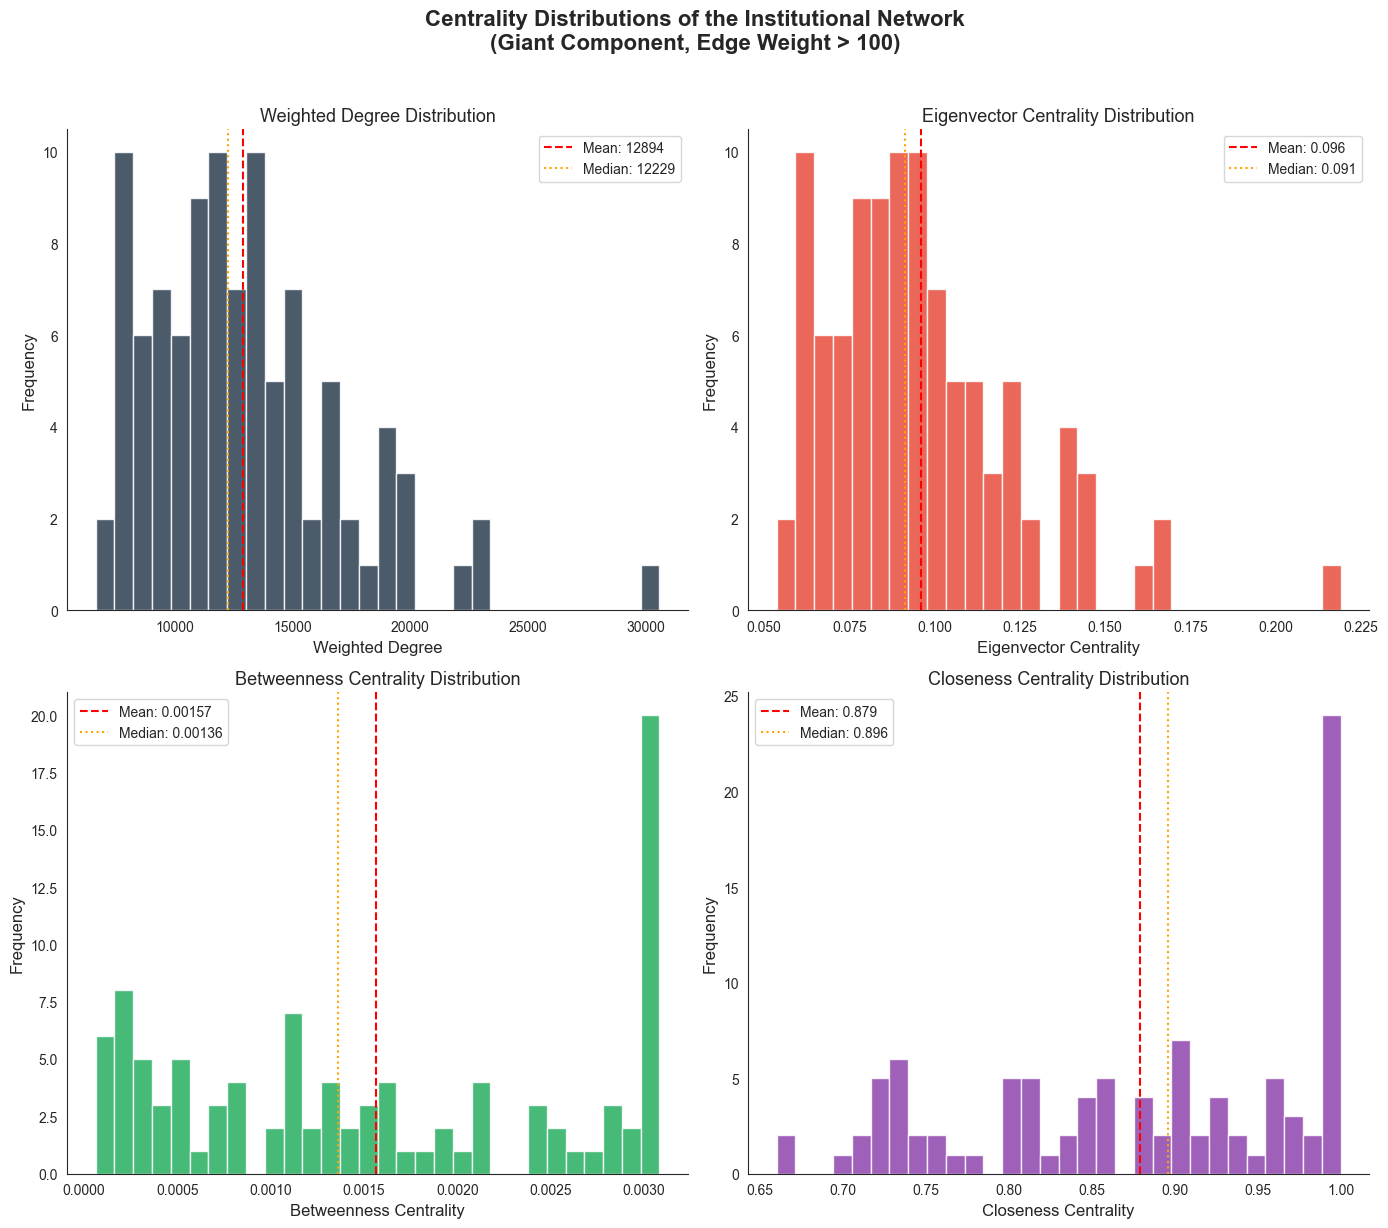


Summary statistics
------------------------------------------------------------
Metric                            Mean       Median      Std Dev
------------------------------------------------------------
Weighted Degree               12893.98     12229.00      4140.70
Eigenvector Centrality          0.0960       0.0914       0.0281
Betweenness Centrality        0.001567     0.001362     0.001078
Closeness Centrality            0.8792       0.8959       0.1013
------------------------------------------------------------


In [ ]:
# Centrality distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle("Centrality Distributions of the Institutional Network\n(Giant Component, Edge Weight > 100)", 
             fontsize=16, fontweight='bold', y=1.02)

# Color palette
colors = ['#2c3e50', '#e74c3c', '#27ae60', '#8e44ad']

# 1. Weighted degree distribution
ax1 = axes[0, 0]
degree_values = list(deg_w.values())
ax1.hist(degree_values, bins=30, color=colors[0], edgecolor='white', alpha=0.85)
ax1.set_xlabel('Weighted Degree', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Weighted Degree Distribution', fontsize=13, fontweight='medium')
ax1.axvline(np.mean(degree_values), color='red', linestyle='--', linewidth=1.5, label=f'Mean: {np.mean(degree_values):.0f}')
ax1.axvline(np.median(degree_values), color='orange', linestyle=':', linewidth=1.5, label=f'Median: {np.median(degree_values):.0f}')
ax1.legend(fontsize=10)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# 2. Eigenvector centrality distribution
ax2 = axes[0, 1]
eigen_values = list(eigenvector.values())
ax2.hist(eigen_values, bins=30, color=colors[1], edgecolor='white', alpha=0.85)
ax2.set_xlabel('Eigenvector Centrality', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Eigenvector Centrality Distribution', fontsize=13, fontweight='medium')
ax2.axvline(np.mean(eigen_values), color='red', linestyle='--', linewidth=1.5, label=f'Mean: {np.mean(eigen_values):.3f}')
ax2.axvline(np.median(eigen_values), color='orange', linestyle=':', linewidth=1.5, label=f'Median: {np.median(eigen_values):.3f}')
ax2.legend(fontsize=10)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# 3. Betweenness centrality distribution
ax3 = axes[1, 0]
betweenness_values = list(betweenness.values())
ax3.hist(betweenness_values, bins=30, color=colors[2], edgecolor='white', alpha=0.85)
ax3.set_xlabel('Betweenness Centrality', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Betweenness Centrality Distribution', fontsize=13, fontweight='medium')
ax3.axvline(np.mean(betweenness_values), color='red', linestyle='--', linewidth=1.5, label=f'Mean: {np.mean(betweenness_values):.5f}')
ax3.axvline(np.median(betweenness_values), color='orange', linestyle=':', linewidth=1.5, label=f'Median: {np.median(betweenness_values):.5f}')
ax3.legend(fontsize=10)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# 4. Closeness centrality distribution
ax4 = axes[1, 1]
closeness_values = list(closeness.values())
ax4.hist(closeness_values, bins=30, color=colors[3], edgecolor='white', alpha=0.85)
ax4.set_xlabel('Closeness Centrality', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.set_title('Closeness Centrality Distribution', fontsize=13, fontweight='medium')
ax4.axvline(np.mean(closeness_values), color='red', linestyle='--', linewidth=1.5, label=f'Mean: {np.mean(closeness_values):.3f}')
ax4.axvline(np.median(closeness_values), color='orange', linestyle=':', linewidth=1.5, label=f'Median: {np.median(closeness_values):.3f}')
ax4.legend(fontsize=10)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nSummary statistics")
print("-" * 60)
print(f"{'Metric':<25} {'Mean':>12} {'Median':>12} {'Std Dev':>12}")
print("-" * 60)
print(f"{'Weighted Degree':<25} {np.mean(degree_values):>12.2f} {np.median(degree_values):>12.2f} {np.std(degree_values):>12.2f}")
print(f"{'Eigenvector Centrality':<25} {np.mean(eigen_values):>12.4f} {np.median(eigen_values):>12.4f} {np.std(eigen_values):>12.4f}")
print(f"{'Betweenness Centrality':<25} {np.mean(betweenness_values):>12.6f} {np.median(betweenness_values):>12.6f} {np.std(betweenness_values):>12.6f}")
print(f"{'Closeness Centrality':<25} {np.mean(closeness_values):>12.4f} {np.median(closeness_values):>12.4f} {np.std(closeness_values):>12.4f}")
print("-" * 60)

**Weighted degree distribution**

The distribution indicates a few institutions have very high connection weights (major hubs like MoMA) while most have moderate connectivity, in line with a scale-free graph.


**Degree assortativity coefficient**

This negative value indicates means that highly connected institutions tend to connect slightly more with less connected ones, rather than forming an exclusive "elite club." However, the value is close to zero, suggesting the network is relatively neutral. Additionally, we need to consider that we are looking to a temporal netwrok (1895-2022), which includes for sure the expansion of the cultural institutions to other institutions, connecting the 'newest' also to the main hubs.
For example, the major institutions (like MoMA) connect broadly across the field rather than only with other major players.


**Eigenvector centrality — influence and prestige**

MoMA leads significantly (0.225), followed by Reina Sofía, Centre Pompidou, and La Biennale di Venezia (which is not a surprise considering we filtered by VB). These institutions are not just well-connected, but connected to other highly influential institutions. This metric reveals the "prestige core" of the contemporary art world: a transatlantic axis linking New York, Paris, Madrid, and Venice, with strong German representation (ZKM, Kunstverein Hamburg, MUMOK). These are the institutions whose exhibition choices and artist selections ripple through the entire network. Important to notice, in the scope of the Master Thesis, is that these institutions are all in the Global North, showing of the major key players realted to the VB (a GN institution) are as well GN institutions.

We confirm this also by plotting the distribution. The right skew distribution reveals an influence hierarchy: a small elite of institutions hold disproportionate prestige, while the majority cluster at lower values. The gap between mean and median shows how top institutions pull the average up.


**Betweenness and closeness centrality — structural position**

The identical scores (betweenness ≈ 0.00041, closeness = 1.0) across the top 10 reveal something important.Tthis result is not that surprising as well, considering we filtered by strenght of the edges. The filtered network forms a nearly complete graph or very dense core. When closeness equals 1.0, it means these nodes can reach every other node in exactly one step — they're directly connected to everyone. This is highly possible considering that there must be at least one artists that co-exhibited in the two (top) institutions. The uniformly low betweenness confirms this: in a dense network, no single institution serves as a critical bridge because there are always alternative paths. This confirms that the weight > 100 threshold has isolated the densely interconnected elite of the art world, where all major institutions share artists extensively with each other.

As far as the distribution is concearned, very low values concentrated near zero with minimal spread. This confirms the network lacks critical bottlenecks — no single institution controls information flow. Additionnally, most values cluster at or near 1.0, confirming the network is highly compact.

Now let's redraw the graphs with the eigenvector centrality measure which seems to be the most interesting one among the ones calculated.

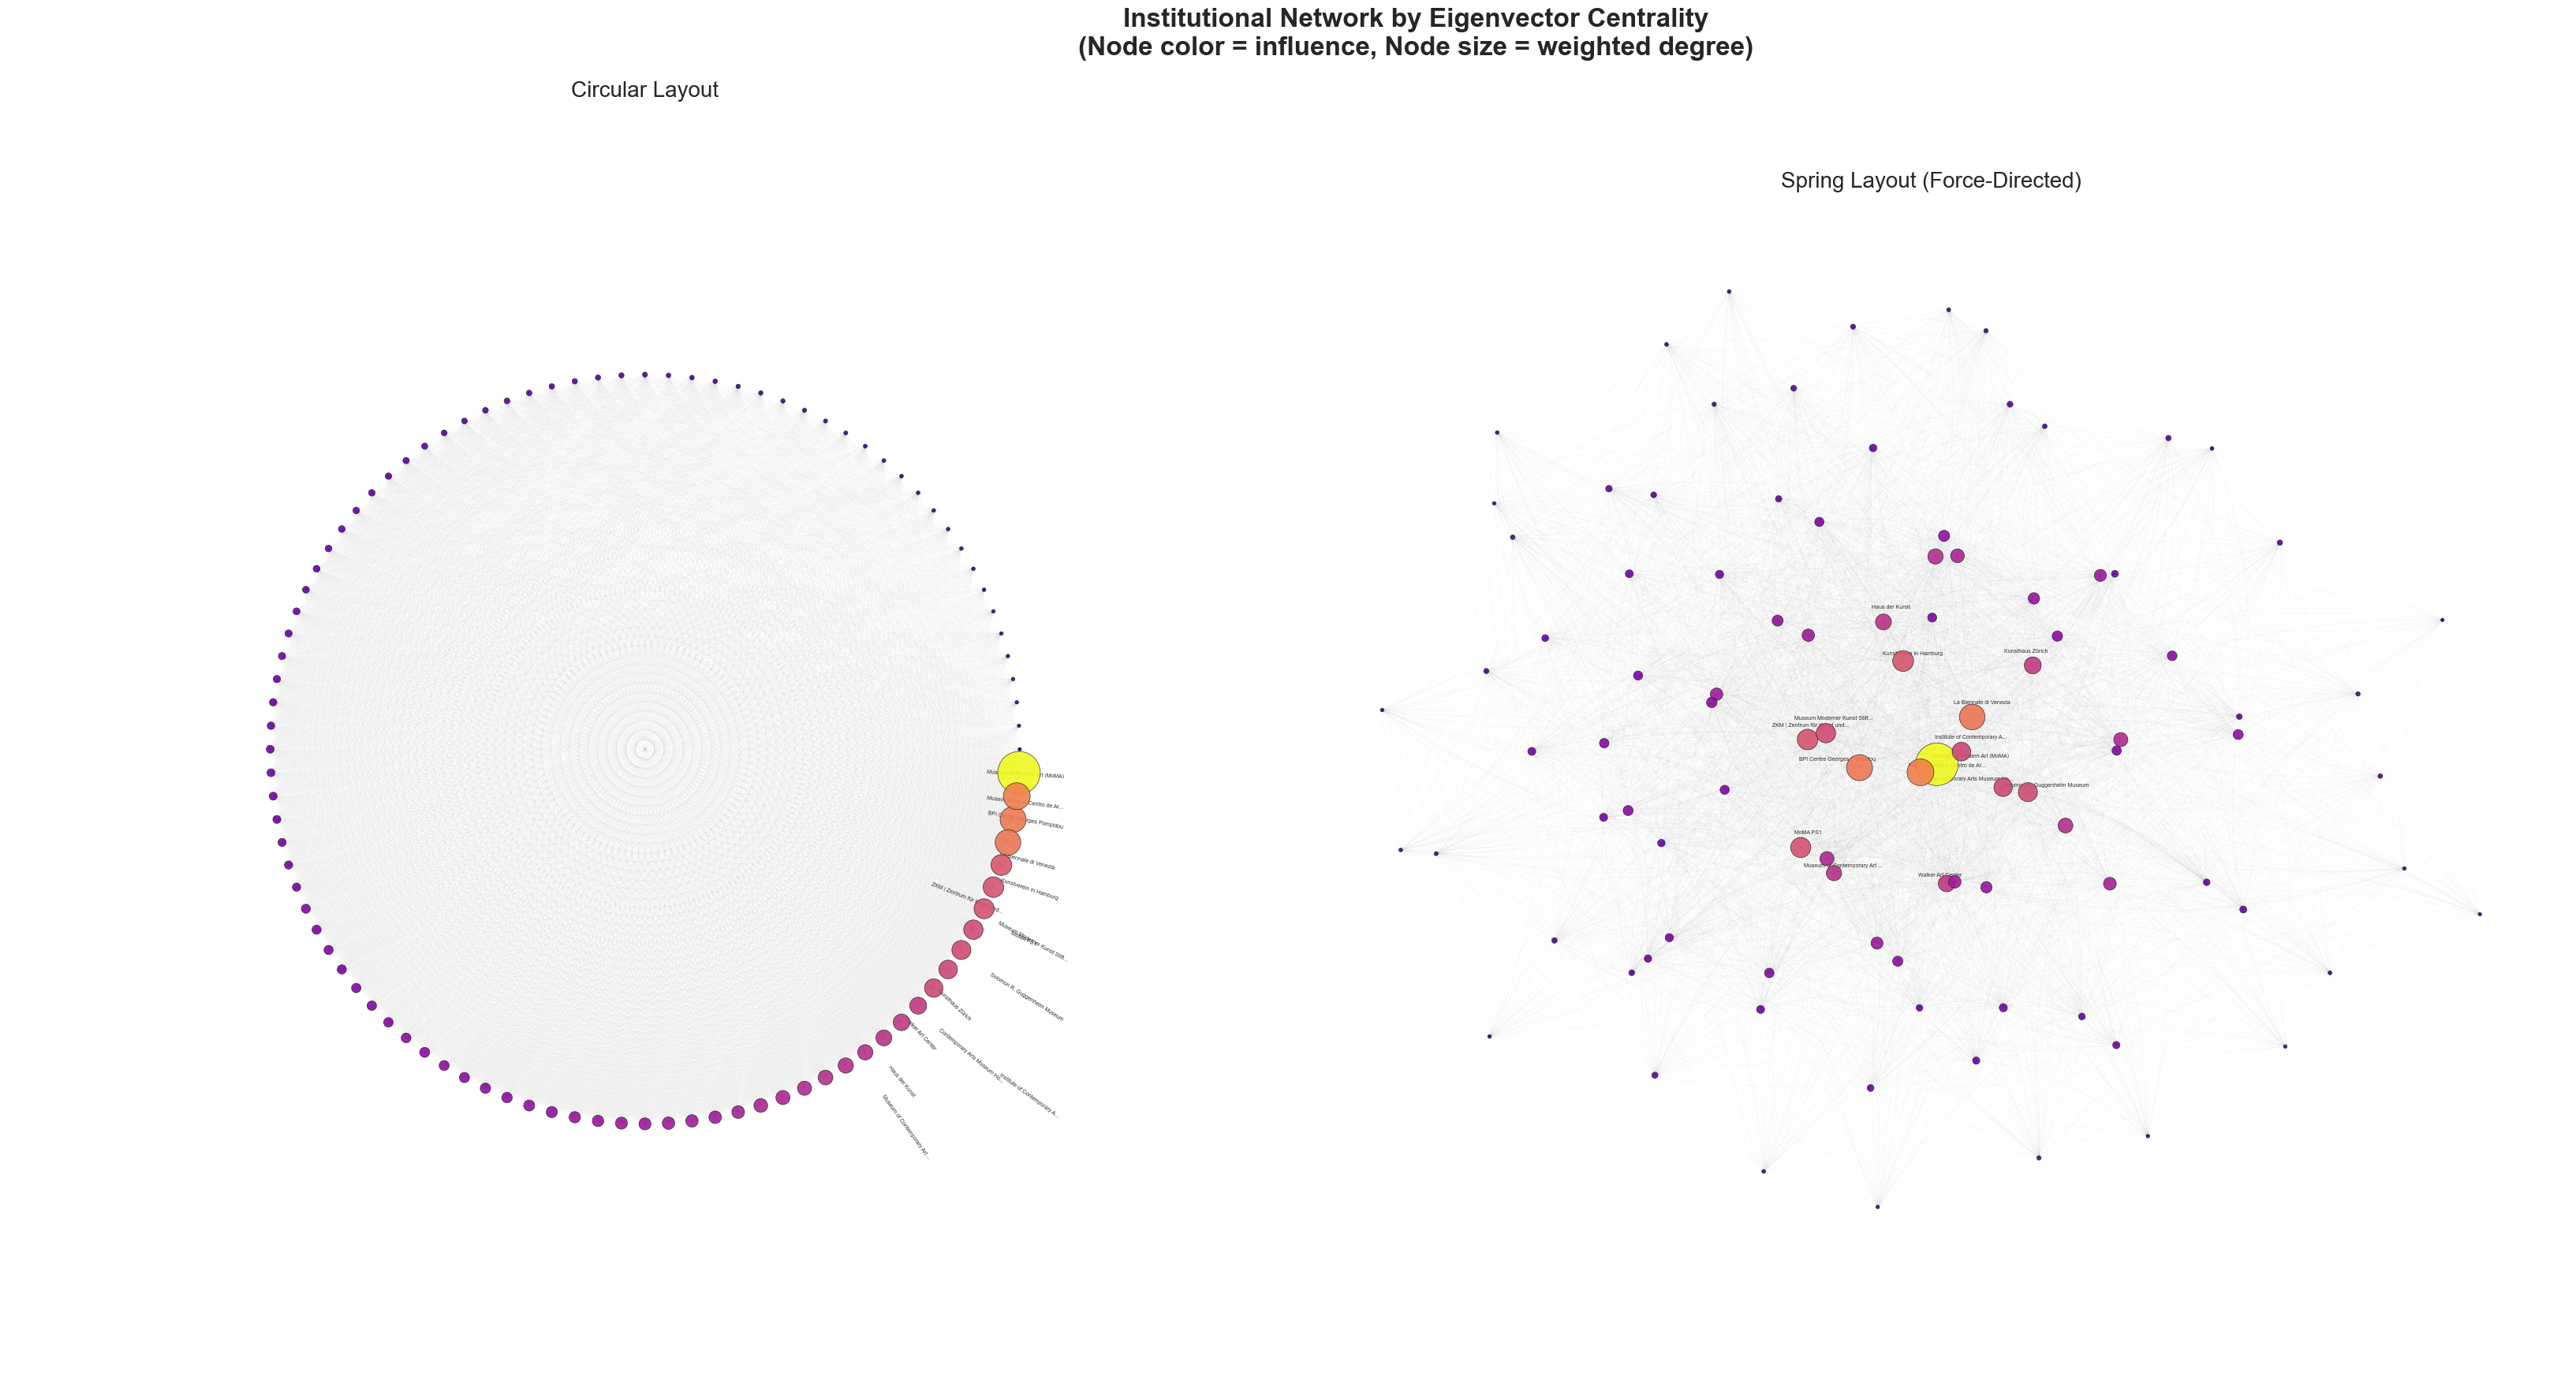

In [ ]:
# Normalize eigenvector centrality for coloring
eigen_vals = np.array(list(eigenvector.values()))
min_eigen, max_eigen = eigen_vals.min(), eigen_vals.max()
norm_eigen = (eigen_vals - min_eigen) / (max_eigen - min_eigen)
norm_eigen_dict = dict(zip(G_giant.nodes(), norm_eigen))

# Create figure with two layouts side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(36, 18))
fig.patch.set_facecolor('white')

# Main title
fig.suptitle(
    "Institutional Network by Eigenvector Centrality\n(Node color = influence, Node size = weighted degree)",
    fontsize=24,
    fontweight="bold",
    y=0.98
)

# Prepare node data
node_list = list(G_giant.nodes())
node_colors_eigen = [norm_eigen_dict[n] for n in node_list]
node_sizes = [node_size_dict[n] for n in node_list]

# Get top 15 by eigenvector centrality for labeling
top15_eigen = [
    n for n, d in sorted(eigenvector.items(),
                         key=lambda x: x[1],
                         reverse=True)[:15]
]

# LEFT: CIRCULAR LAYOUT
ax1.set_facecolor('white')
ax1.set_title("Circular Layout", fontsize=20, pad=15)

# Draw curved edges
draw_curved_edges(G_giant, pos_circular, ax1, alpha=0.04, color="#555555", curve_to_center=True)

# Draw nodes with eigenvector centrality as color
scatter1 = ax1.scatter(
    [pos_circular[n][0] for n in node_list],
    [pos_circular[n][1] for n in node_list],
    s=node_sizes,
    c=node_colors_eigen,
    cmap="plasma",
    alpha=0.9,
    edgecolors="#222222",
    linewidths=0.5,
    zorder=10
)

# Add labels for top 15 eigenvector nodes
add_labels(pos_circular, top15_eigen, id_to_name, ax1, layout_type="circular")

ax1.set_aspect('equal')
ax1.set_xlim(-1.7, 1.7)
ax1.set_ylim(-1.7, 1.7)
ax1.axis("off")

# RIGHT: SPRING LAYOUT
ax2.set_facecolor('white')
ax2.set_title("Spring Layout (Force-Directed)", fontsize=20, pad=15)

# Draw curved edges
draw_curved_edges(G_giant, pos_spring, ax2, alpha=0.04, color="#555555", curve_to_center=False)

# Draw nodes
scatter2 = ax2.scatter(
    [pos_spring[n][0] for n in node_list],
    [pos_spring[n][1] for n in node_list],
    s=node_sizes,
    c=node_colors_eigen,
    cmap="plasma",
    alpha=0.9,
    edgecolors="#222222",
    linewidths=0.5,
    zorder=10
)

# Add labels for top 15 eigenvector nodes
add_labels(pos_spring, top15_eigen, id_to_name, ax2, layout_type="spring")

ax2.set_aspect('equal')
x_coords = [pos_spring[n][0] for n in node_list]
y_coords = [pos_spring[n][1] for n in node_list]
margin = 0.15
ax2.set_xlim(min(x_coords) - margin, max(x_coords) + margin)
ax2.set_ylim(min(y_coords) - margin, max(y_coords) + margin)
ax2.axis("off")

plt.tight_layout(rect=[0, 0, 0.91, 0.96])
plt.savefig("network_eigenvector.png", dpi=300, facecolor="white", bbox_inches="tight")
plt.show()

### Section 3_Network Validation

In [57]:
# Generate Degree-Preserving Null Networks

# Number of null networks to generate
n_null = 200

# Reduced number of swaps (dense networks can't swap as much)
n_swaps = G_giant.number_of_edges() * 2

print(f"Network size: {G_giant.number_of_nodes()} nodes, {G_giant.number_of_edges()} edges")
print(f"Generating {n_null} null networks...")

# Store null networks
null_networks = []

for i in range(n_null):
    # Create a copy of the original network
    G_null = G_giant.copy()
    
    # Perform double-edge swaps (preserves degree sequence exactly)
    try:
        nx.double_edge_swap(G_null, nswap=n_swaps, max_tries=n_swaps*100)
    except nx.NetworkXAlgorithmError:
        # If max swaps not achieved, keep the partially swapped network
        pass
    
    null_networks.append(G_null)
    
    # Progress update every 100 networks
    if (i + 1) % 100 == 0:
        print(f"  Generated {i + 1}/{n_null} null networks")

print(f"\nDone! Created {len(null_networks)} degree-preserving null networks.")

Network size: 100 nodes, 4190 edges
Generating 200 null networks...
  Generated 100/200 null networks
  Generated 200/200 null networks

Done! Created 200 degree-preserving null networks.


Calculating metrics for null networks...
  Processed 50/200 null networks
  Processed 100/200 null networks
  Processed 150/200 null networks
  Processed 200/200 null networks
Done calculating metrics!


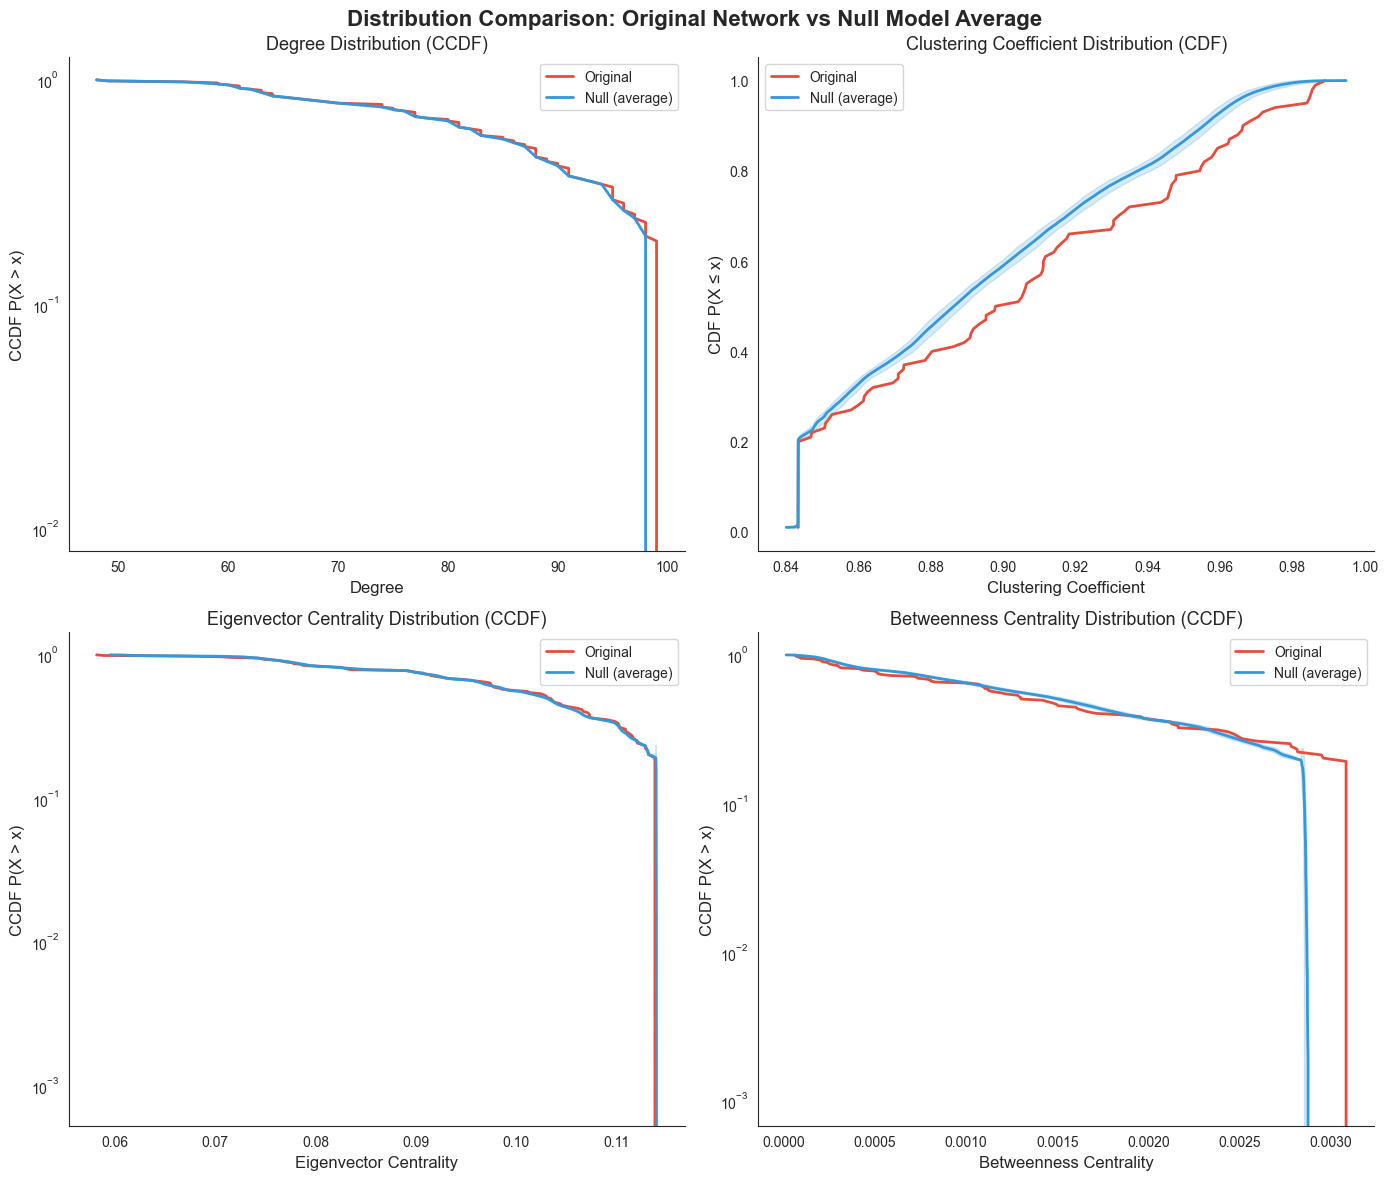

In [ ]:
# CDF Comparison: Original Network vs Null Networks

def compute_ecdf(data):
    """Compute empirical CDF"""
    sorted_data = np.sort(data)
    ecdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, ecdf

def compute_ccdf(data):
    """Compute complementary CDF (1 - CDF)"""
    sorted_data = np.sort(data)
    ccdf = 1 - np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, ccdf


# Calculate metrics for original network
orig_degree = np.array([d for n, d in G_giant.degree()])
orig_clustering = np.array(list(nx.clustering(G_giant).values()))
orig_eigenvector = np.array(list(nx.eigenvector_centrality(G_giant, max_iter=1000).values()))
orig_betweenness = np.array(list(nx.betweenness_centrality(G_giant).values()))


# Calculate metrics for null networks
print("Calculating metrics for null networks...")

null_degrees = []
null_clustering = []
null_eigenvector = []
null_betweenness = []

for i, G_null in enumerate(null_networks):
    null_degrees.append([d for n, d in G_null.degree()])
    null_clustering.append(list(nx.clustering(G_null).values()))
    
    try:
        null_eigenvector.append(list(nx.eigenvector_centrality(G_null, max_iter=1000).values()))
    except:
        null_eigenvector.append(list(nx.eigenvector_centrality(G_null, max_iter=2000, tol=1e-4).values()))
    
    null_betweenness.append(list(nx.betweenness_centrality(G_null).values()))
    
    if (i + 1) % 50 == 0:
        print(f"  Processed {i + 1}/{len(null_networks)} null networks")

print("Done calculating metrics!")


# Plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle("Distribution Comparison: Original Network vs Null Model Average", 
             fontsize=16, fontweight='bold')

# Color scheme
orig_color = '#e74c3c'  # Red for original
null_color = '#3498db'  # Blue for null average

# 1. Degree Distribution (CCDF)
ax1 = axes[0, 0]

# Original
x_orig, ccdf_orig = compute_ccdf(orig_degree)
ax1.plot(x_orig, ccdf_orig, color=orig_color, linewidth=2, label='Original')

# Null average - compute CCDF for each null network, then average
all_x = np.sort(np.unique(np.concatenate(null_degrees)))
null_ccdfs = []
for nd in null_degrees:
    x_null, ccdf_null = compute_ccdf(np.array(nd))
    # Interpolate to common x values
    ccdf_interp = np.interp(all_x, x_null, ccdf_null, right=0)
    null_ccdfs.append(ccdf_interp)

avg_ccdf = np.mean(null_ccdfs, axis=0)
std_ccdf = np.std(null_ccdfs, axis=0)

ax1.plot(all_x, avg_ccdf, color=null_color, linewidth=2, label='Null (average)')
ax1.fill_between(all_x, avg_ccdf - std_ccdf, avg_ccdf + std_ccdf, color=null_color, alpha=0.2)

ax1.set_xlabel('Degree', fontsize=12)
ax1.set_ylabel('CCDF P(X > x)', fontsize=12)
ax1.set_title('Degree Distribution (CCDF)', fontsize=13)
ax1.legend()
ax1.set_yscale('log')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# 2. Clustering Coefficient (CDF)
ax2 = axes[0, 1]

# Original
x_orig, cdf_orig = compute_ecdf(orig_clustering)
ax2.plot(x_orig, cdf_orig, color=orig_color, linewidth=2, label='Original')

# Null average
all_x = np.sort(np.unique(np.concatenate(null_clustering)))
null_cdfs = []
for nc in null_clustering:
    x_null, cdf_null = compute_ecdf(np.array(nc))
    cdf_interp = np.interp(all_x, x_null, cdf_null, right=1)
    null_cdfs.append(cdf_interp)

avg_cdf = np.mean(null_cdfs, axis=0)
std_cdf = np.std(null_cdfs, axis=0)

ax2.plot(all_x, avg_cdf, color=null_color, linewidth=2, label='Null (average)')
ax2.fill_between(all_x, avg_cdf - std_cdf, avg_cdf + std_cdf, color=null_color, alpha=0.2)

ax2.set_xlabel('Clustering Coefficient', fontsize=12)
ax2.set_ylabel('CDF P(X ≤ x)', fontsize=12)
ax2.set_title('Clustering Coefficient Distribution (CDF)', fontsize=13)
ax2.legend()
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# 3. Eigenvector Centrality (CCDF)
ax3 = axes[1, 0]

# Original
x_orig, ccdf_orig = compute_ccdf(orig_eigenvector)
ax3.plot(x_orig, ccdf_orig, color=orig_color, linewidth=2, label='Original')

# Null average
all_x = np.sort(np.unique(np.concatenate(null_eigenvector)))
null_ccdfs = []
for ne in null_eigenvector:
    x_null, ccdf_null = compute_ccdf(np.array(ne))
    ccdf_interp = np.interp(all_x, x_null, ccdf_null, right=0)
    null_ccdfs.append(ccdf_interp)

avg_ccdf = np.mean(null_ccdfs, axis=0)
std_ccdf = np.std(null_ccdfs, axis=0)

ax3.plot(all_x, avg_ccdf, color=null_color, linewidth=2, label='Null (average)')
ax3.fill_between(all_x, avg_ccdf - std_ccdf, avg_ccdf + std_ccdf, color=null_color, alpha=0.2)

ax3.set_xlabel('Eigenvector Centrality', fontsize=12)
ax3.set_ylabel('CCDF P(X > x)', fontsize=12)
ax3.set_title('Eigenvector Centrality Distribution (CCDF)', fontsize=13)
ax3.legend()
ax3.set_yscale('log')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# 4. Betweenness Centrality (CCDF)
ax4 = axes[1, 1]

# Original
x_orig, ccdf_orig = compute_ccdf(orig_betweenness)
ax4.plot(x_orig, ccdf_orig, color=orig_color, linewidth=2, label='Original')

# Null average
all_x = np.sort(np.unique(np.concatenate(null_betweenness)))
null_ccdfs = []
for nb in null_betweenness:
    x_null, ccdf_null = compute_ccdf(np.array(nb))
    ccdf_interp = np.interp(all_x, x_null, ccdf_null, right=0)
    null_ccdfs.append(ccdf_interp)

avg_ccdf = np.mean(null_ccdfs, axis=0)
std_ccdf = np.std(null_ccdfs, axis=0)

ax4.plot(all_x, avg_ccdf, color=null_color, linewidth=2, label='Null (average)')
ax4.fill_between(all_x, avg_ccdf - std_ccdf, avg_ccdf + std_ccdf, color=null_color, alpha=0.2)

ax4.set_xlabel('Betweenness Centrality', fontsize=12)
ax4.set_ylabel('CCDF P(X > x)', fontsize=12)
ax4.set_title('Betweenness Centrality Distribution (CCDF)', fontsize=13)
ax4.legend()
ax4.set_yscale('log')
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig("cdf_comparison.png", dpi=300, facecolor="white", bbox_inches="tight")
plt.show()

#### Section 4: Network sampling

In [ ]:
# Original network info
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()
target_fraction = 0.15  # 15% of nodes

print(f"Original network: {n_nodes} nodes, {n_edges} edges")
print(f"Target sample size: ~{int(n_nodes * target_fraction)} nodes ({target_fraction*100:.0f}%)")

# Random vertex sampling
sample_size = int(n_nodes * target_fraction)
sampled_nodes = random.sample(list(G.nodes()), sample_size)
G_sample = G.subgraph(sampled_nodes).copy()

print(f"\nRandom vertex sampling")
print(f"   Nodes: {G_sample.number_of_nodes()} ({G_sample.number_of_nodes()/n_nodes*100:.1f}%)")
print(f"   Edges: {G_sample.number_of_edges()} ({G_sample.number_of_edges()/n_edges*100:.1f}%)")
print(f"   Density: {nx.density(G_sample):.4f}")
print(f"   Weakly connected components: {nx.number_weakly_connected_components(G_sample)}")

Original network: 21739 nodes, 18471870 edges
Target sample size: ~3260 nodes (15%)

Random vertex sampling
   Nodes: 3260 (15.0%)
   Edges: 409682 (2.2%)
   Density: 0.0386
   Weakly connected components: 46
   Strongly connected components: 3260


We sampled 15% of nodes but retained only 2.2% of edges. This is expected with vertex sampling. This confirms your network has relatively uniform edge distribution rather than being concentrated among a small subset of nodes.The probability of having a hub is indeed really low as well.

The original network is denser than the sample (density 0.0386 in sample). This happens because vertex sampling tends to break apart the structure. Edges connecting sampled nodes to non-sampled nodes are lost entirely, reducing the apparent connectivity.

We went from a connected (or nearly connected) network to 46 weakly connected components. Random vertex sampling tends to create isolated fragments because it doesn't preserve paths. Nodes that were connected through intermediaries in the original network become disconnected when those bridge nodes aren't sampled. We have to rememebr that each node was indeed contected to the VB.

**Random vertex sampling** I guess is best for estimating node-level attributes where connectivity doesn't really matter. If I wanted to study the geographic distribution of institutions, their founding years, or collection sizes, this method provides some estimates. It's statistically simple and each node has equal probability of selection. However, as our results showed, it fragments the network severely — unsuitable for any analysis involving paths, communities, or influence flow.

**Random edge sampling** suits research focused on relationships between institutions. Questions like "what characterizes strong institutional ties" or "how are collaboration weights distributed" are well-served by this approach. If I rememebr correctly from class, it naturally oversamples high-degree hubs - in this case like MoMA and Pompidou, which is advantageous when studying the elite core but introduces bias against peripheral institutions with few connections.

**Snowball sampling** is ideal for community-focused research or studying influence propagation. If I wanted to map the European contemporary art cluster or trace how exhibition practices spread from major museums outward, snowball sampling from relevant seeds would preserve local structure intact. Normally, the tradeoff is the dependency on seed selection and bias toward densely connected regions, potentially missing isolated but significant institutions.